In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
from physicsconstants import PhysicsConstants
units = PhysicsConstants()

### Load up Monte Carlo

In [4]:
import h5py
mcF = h5py.File('/data/ana/SterileNeutrino/IC86/HighEnergy/SPE_Templates/Nominal/Ares/IC86.AVG/Merged/Ares_IC86.AVG_0.97_cuts_platinum_5000.h5', 'r')
print(mcF['keysDict'][()].dtype.names)

('Run', 'Event', 'SubEvent', 'SubEventStream', 'exists', 'AvgDistQ', 'AvgDistQ_DC', 'AvgDistQ_NoDC', 'BayesLLHR', 'COGr_DC', 'COGr_NoDC', 'COGz_DC', 'COGz_NoDC', 'DirL', 'DirL_NoDC', 'DirNDoms', 'DirNDoms_NoDC', 'DirNPulses', 'DirNPulses_NoDC', 'DirNStrings', 'DirNStrings_NoDC', 'DirS', 'DirS_NoDC', 'EventID', 'InjectionRadius', 'MuExAzimuth', 'MuExCOGR', 'MuExCOGZ', 'MuExEnergy', 'MuExZenith', 'MuonAzimuth', 'MuonEnergy', 'MuonZenith', 'NChan', 'NChan_NoDC', 'NuAzimuth', 'NuEnergy', 'NuZenith', 'OuterCharge', 'Overburden', 'ParaboloidSigma', 'PrimaryType', 'Qtot', 'Qtot_NoDC', 'RLogL', 'RunID', 'Separation', 'weights')


In [5]:
PrimaryType     = mcF['keysDict'][()]['PrimaryType']
NuEnergy        = mcF['keysDict'][()]['NuEnergy']
NuZenith        = mcF['keysDict'][()]['NuZenith']
Overburden      = mcF['keysDict'][()]['Overburden']
ParaboloidSigma = mcF['keysDict'][()]['ParaboloidSigma']
RLogL           = mcF['keysDict'][()]['RLogL']
BayesLLHR       = mcF['keysDict'][()]['BayesLLHR']
DirNDoms        = mcF['keysDict'][()]['DirNDoms']

## Get fluxes at detector :—)

In [6]:
import nuSQUIDSpy as nsq

# nuSQuIDS params
from controls import theta_12, theta_23, theta_13, delta, delta_m_21, delta_m_31, r_earth
interactions     = True
tau_regeneration = True

### Solar fluxes

In [80]:
slc = slice(None, None, 8) # Use 1/8 of data for efficiency
# Load up the fluxes
nu_flux     = np.genfromtxt('data/PostPropagation/SIBYLL2.3_pp_CombinedGHAndHG_H4a_nu.txt')
nubar_flux  = np.genfromtxt('data/PostPropagation/SIBYLL2.3_pp_CombinedGHAndHG_H4a_nubar.txt')
solar_ee    = nu_flux[:,0][slc]
solar_czens = np.linspace(min(np.cos(NuZenith)), max(np.cos(NuZenith)), 40)
flux        = np.hstack([nu_flux[:,1:][slc], nubar_flux[:,1:][slc]])

# Get inital flux into the form nuSQuIDS expects
initial_flux = np.zeros((len(flux[:,0]), 2, 3))
for i in range(3):
    initial_flux[:,0,i] = flux[:, i]
    initial_flux[:,1,i] = flux[:, i+3]

solar_detector_flux = np.zeros((len(flux[:,0]), 2, 3, len(solar_czens)))
for i, czen in enumerate(solar_czens):
    zen = np.arccos(czen)
    chord  = 2*r_earth*np.sin(zen/2)
    nuSQ = nsq.nuSQUIDS(solar_ee*units.GeV, 3, nsq.NeutrinoType.both, interactions)
    nuSQ.Set_abs_error(1.0e-10)
    nuSQ.Set_rel_error(1.0e-10)

    nuSQ.Set_SquareMassDifference(1, delta_m_21)
    nuSQ.Set_SquareMassDifference(2, delta_m_31)
    nuSQ.Set_MixingAngle(0, 1, theta_12)
    nuSQ.Set_MixingAngle(0, 2, theta_13)
    nuSQ.Set_MixingAngle(1, 2, theta_23)
    nuSQ.Set_CPPhase(0,2,delta)

    nuSQ.Set_Body(nsq.Earth())
    nuSQ.Set_Track(nsq.Earth.Track(chord))
    nuSQ.Set_TauRegeneration(True)
    nuSQ.Set_initial_state(initial_flux, nsq.Basis.flavor)
    nuSQ.EvolveState()
    
    for j in range(3):
        solar_detector_flux[:,0,j,i] = [nuSQ.EvalFlavor(j,e*units.GeV,0) for e in solar_ee]
        solar_detector_flux[:,1,j,i] = [nuSQ.EvalFlavor(j,e*units.GeV,1) for e in solar_ee]


### Conventional atm fluxes

In [81]:
slc = slice(None, None, 7) # Only use 1/7 of the data for efficiency
# Load up fluxes
flux       = np.genfromtxt('../solar_WIMP/data/AIRS_flux_sib_HG.dat')
conv_czens = np.array(sorted(set(flux[:,0])))[::2]
conv_ee    = np.array(sorted(set(flux[:,1])))[slc]

# Get inital flux into the form nuSQuIDS expects
initial_flux = np.zeros((len(conv_ee), 2, 3))
for i in range(3):
    if i!=2:
        initial_flux[:,0,i] = flux[:,2*i+2][:350][slc]
        initial_flux[:,1,i] = flux[:,2*i+3][:350][slc]
    else:
        initial_flux[:,0,i] = 0
        initial_flux[:,1,i] = 0

conv_detector_flux = np.zeros((len(conv_ee), 2, 3, len(conv_czens)))
for i, czen in enumerate(conv_czens):
    zen = np.arccos(czen)
    chord  = 2*r_earth*np.sin(zen/2)
    nuSQ = nsq.nuSQUIDS(conv_ee*units.GeV, 3, nsq.NeutrinoType.both, interactions)
    nuSQ.Set_abs_error(1.0e-10)
    nuSQ.Set_rel_error(1.0e-10)

    nuSQ.Set_SquareMassDifference(1, delta_m_21)
    nuSQ.Set_SquareMassDifference(2, delta_m_31)
    nuSQ.Set_MixingAngle(0, 1, theta_12)
    nuSQ.Set_MixingAngle(0, 2, theta_13)
    nuSQ.Set_MixingAngle(1, 2, theta_23)
    nuSQ.Set_CPPhase(0,2,delta)

    nuSQ.Set_Body(nsq.Earth())
    nuSQ.Set_Track(nsq.Earth.Track(chord))
    nuSQ.Set_TauRegeneration(True)
    nuSQ.Set_initial_state(initial_flux, nsq.Basis.flavor)
    nuSQ.EvolveState()
    
    for j in range(3):
        conv_detector_flux[:,0,j,i] = [nuSQ.EvalFlavor(j,e*units.GeV,0) for e in conv_ee]
        conv_detector_flux[:,1,j,i] = [nuSQ.EvalFlavor(j,e*units.GeV,1) for e in conv_ee]


## Let's get interpolating

In [82]:
from scipy.interpolate import bisplrep, bisplev

### Interpolate solar atmospherics

In [87]:
len(conv_czens)

50

In [135]:
x, y = np.mgrid[np.log(solar_ee[0]):np.log(solar_ee[-1]):46j, solar_czens[0]:solar_czens[-1]:40j]

solar_nu_bitck    = bisplrep(x, y, np.log(solar_detector_flux[:,0,1,:]), s=1e5)
solar_nubar_bitck = bisplrep(x, y, np.log(solar_detector_flux[:,1,1,:]), s=1e5)

def get_solar_flux(e, zen, pt):
    if e<1e1 or e>1e5:
        return 0
    else:
        le = np.log(e)
        cz = np.cos(zen)
        if pt==14:
            return np.exp(bisplev(le, cz, solar_nu_bitck))
        elif pt==-14:
            return np.exp(bisplev(le, cz, solar_nubar_bitck))
        else:
            print('Wrong primary type sucka !')


x, y = np.mgrid[np.log(conv_ee[0]):np.log(conv_ee[-1]):50j, conv_czens[0]:conv_czens[-1]:50j]

conv_nu_bitck    = bisplrep(x, y, np.log(conv_detector_flux[:,0,1,:]), s=1)
conv_nubar_bitck = bisplrep(x, y, np.log(conv_detector_flux[:,1,1,:]), s=1)

def get_conv_flux(e, zen, pt):
    if e<1e2 or e>1e6:
        return 0
    else:
        le = np.log(e)
        cz = np.cos(zen)
        if pt==14:
            return np.exp(bisplev(le, cz, conv_nu_bitck))
        elif pt==-14:
            return np.exp(bisplev(le, cz, conv_nubar_bitck))
        else:
            print('Wrong primary type sucka !')

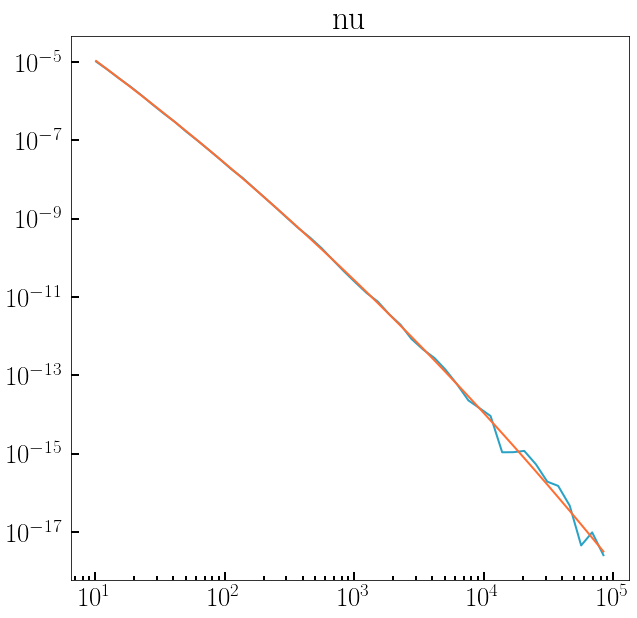

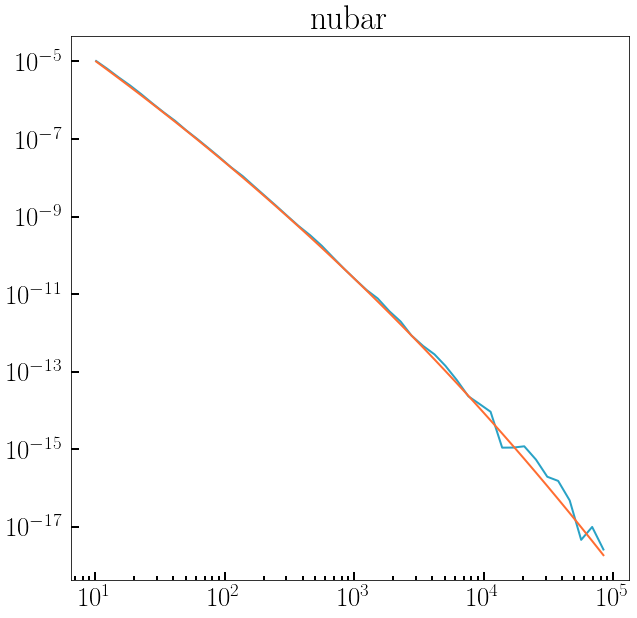

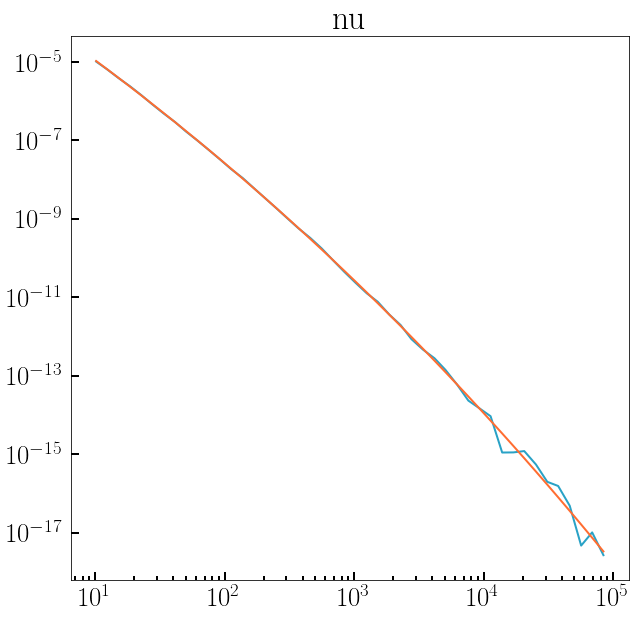

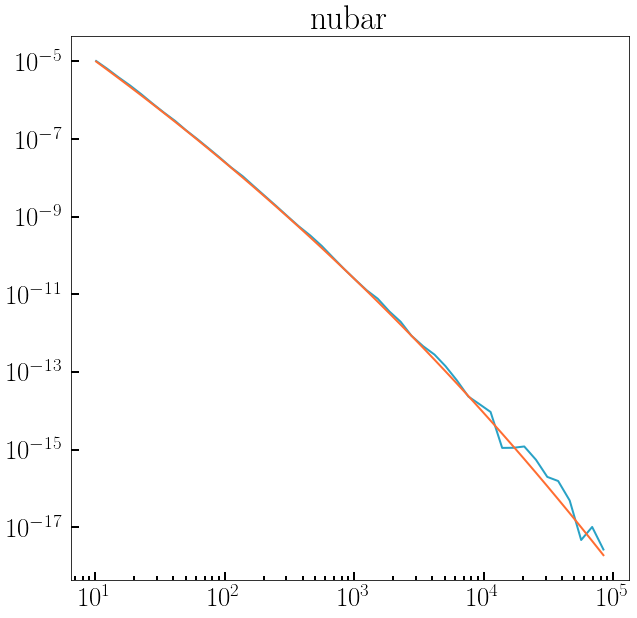

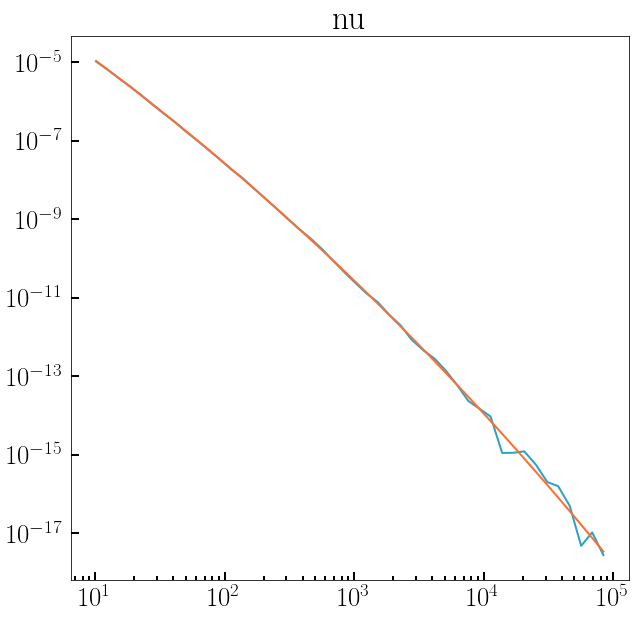

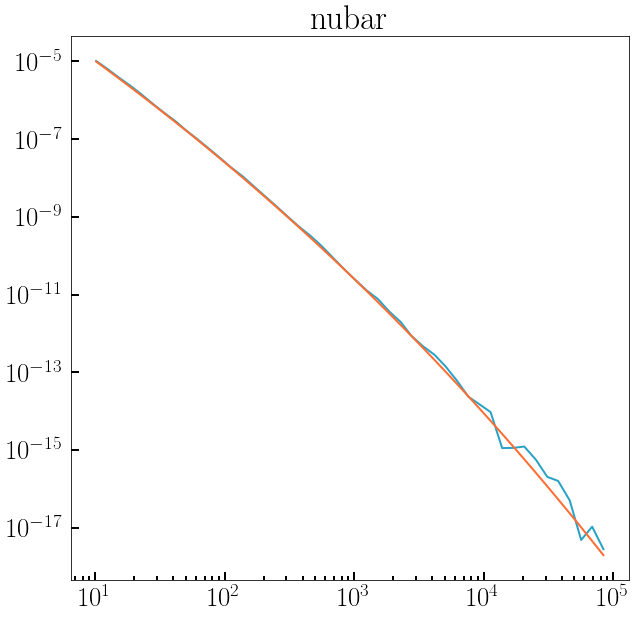

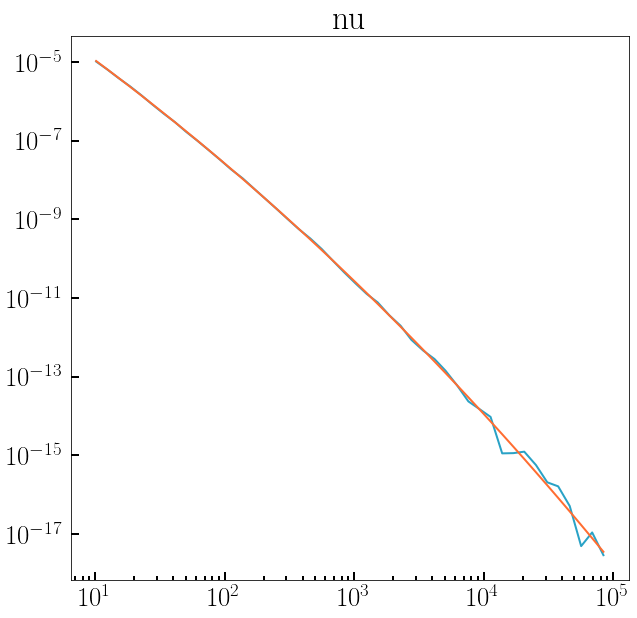

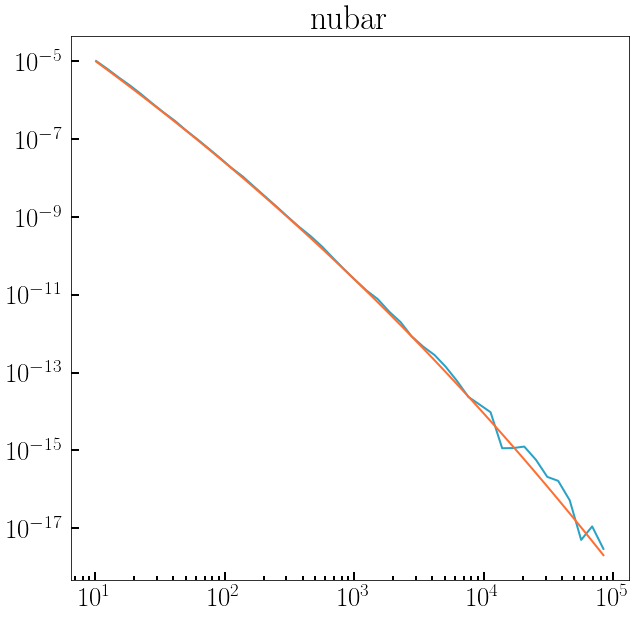

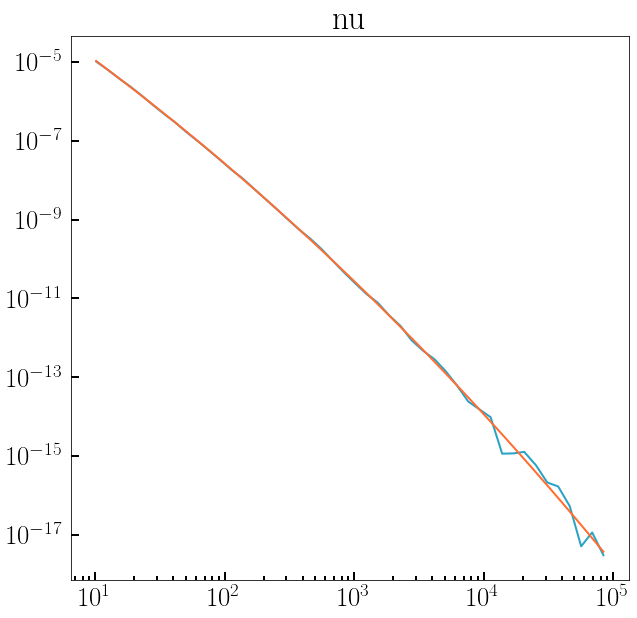

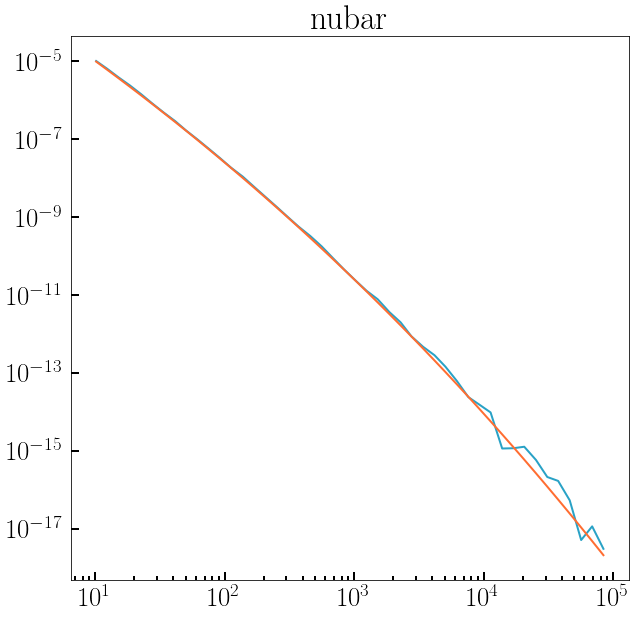

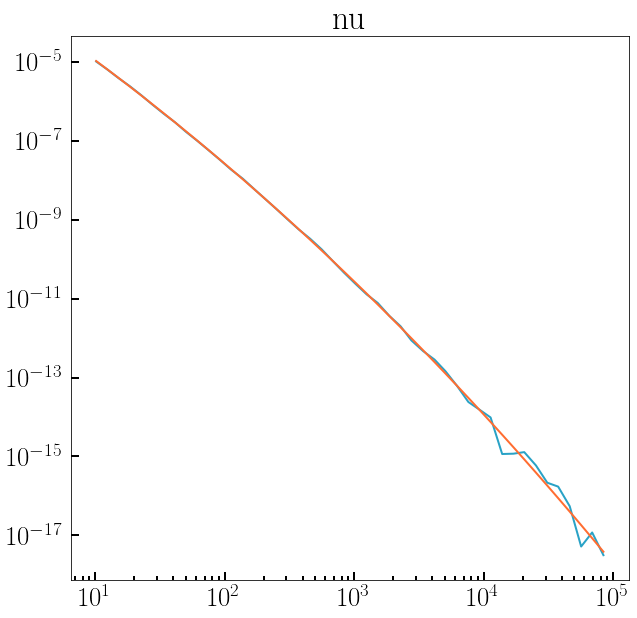

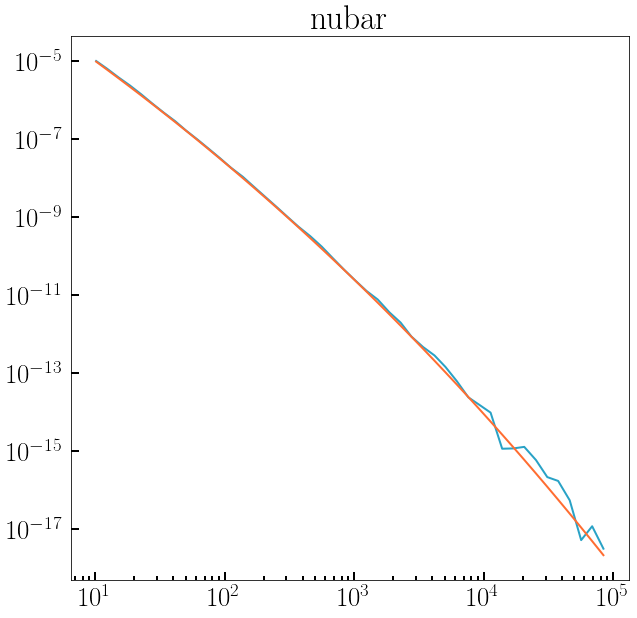

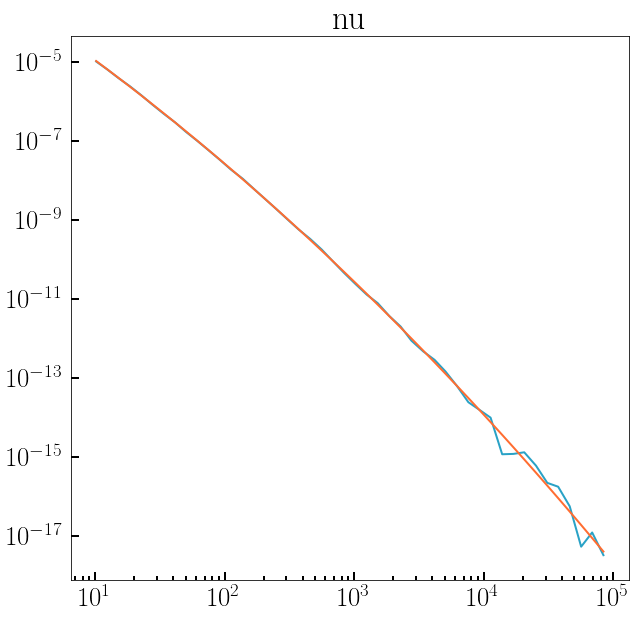

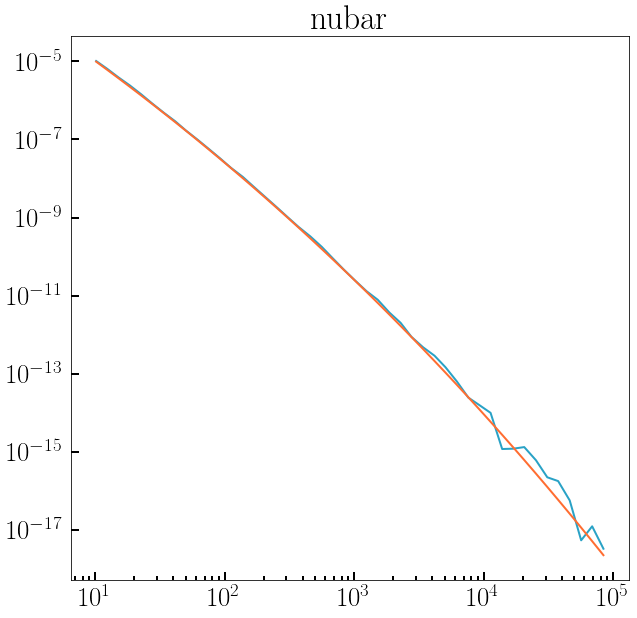

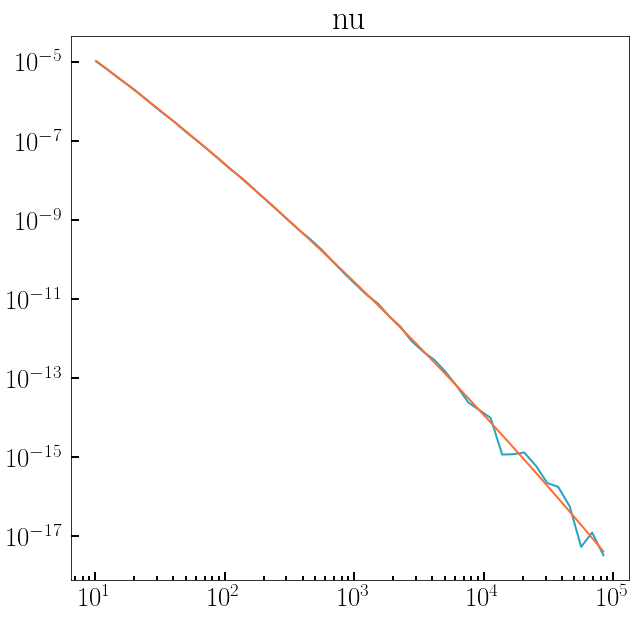

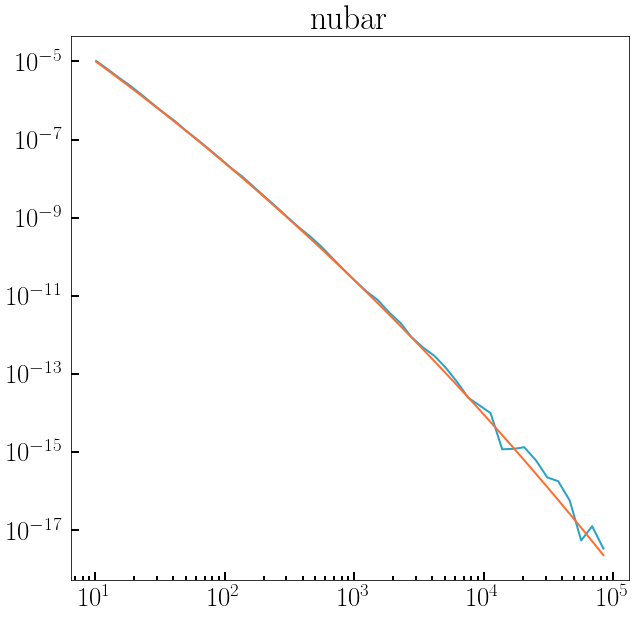

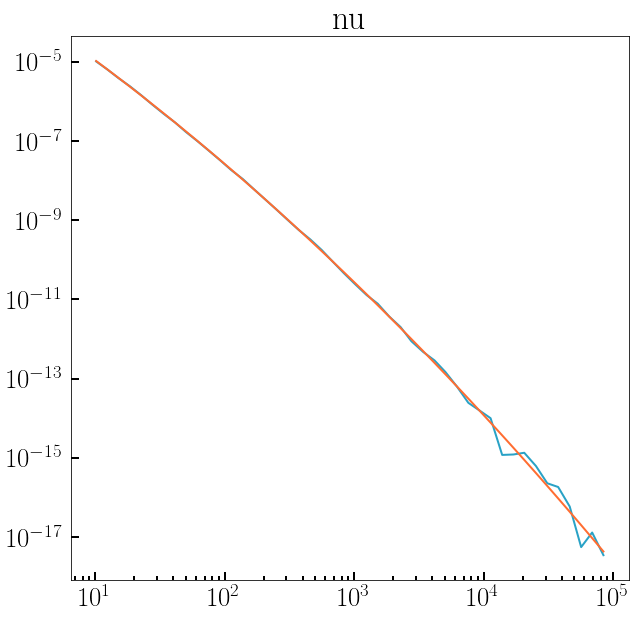

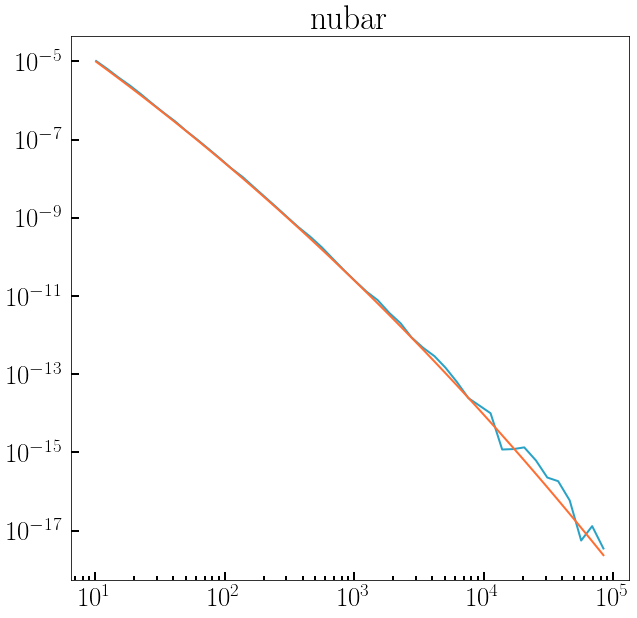

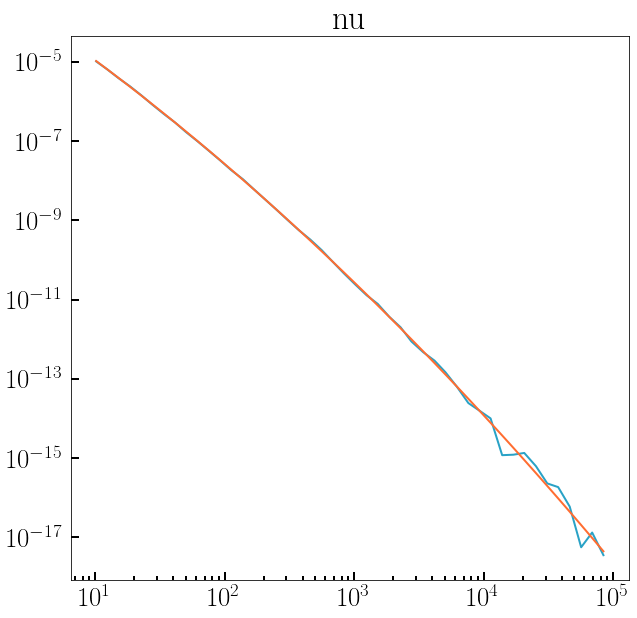

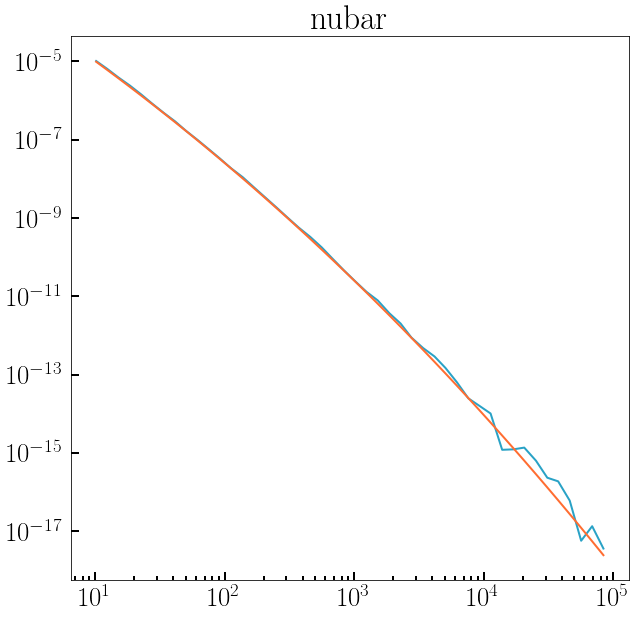

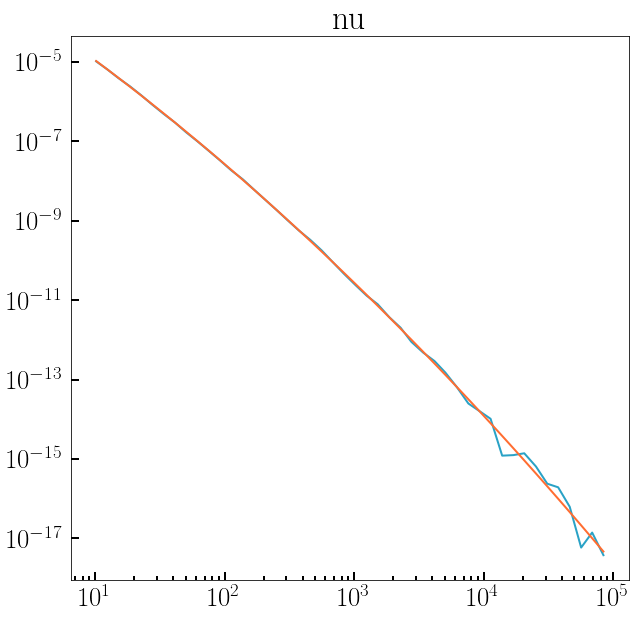

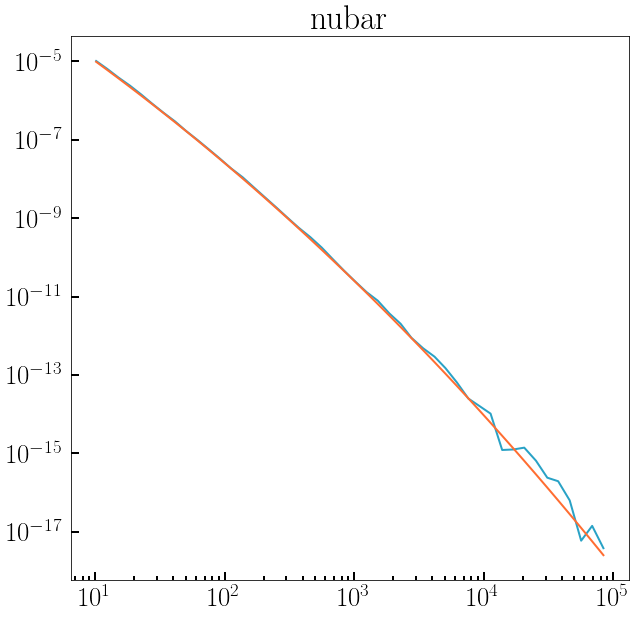

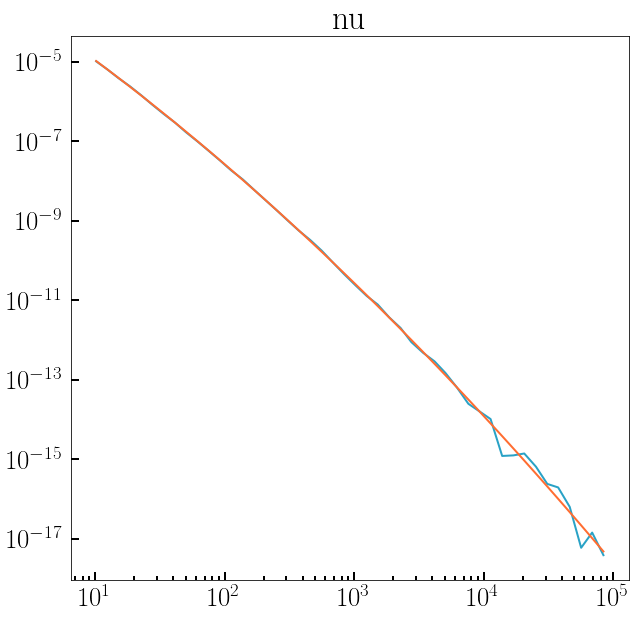

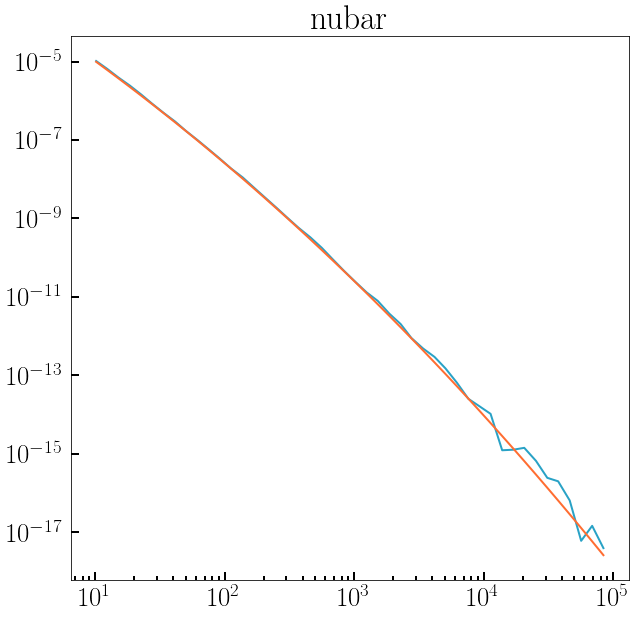

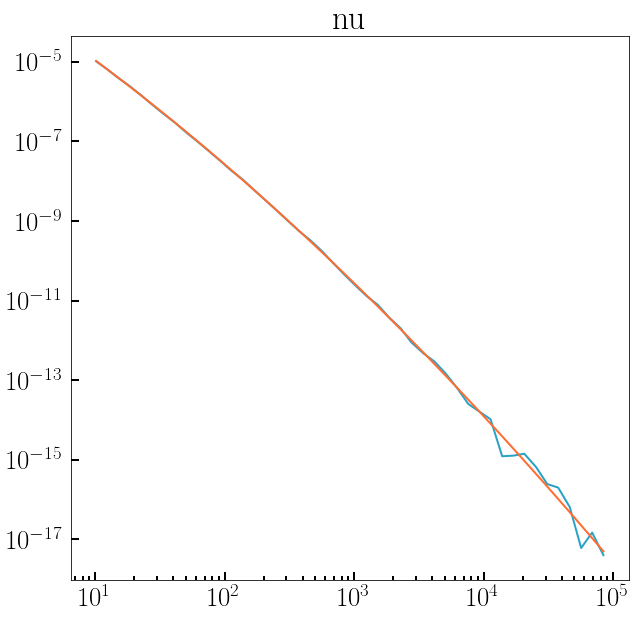

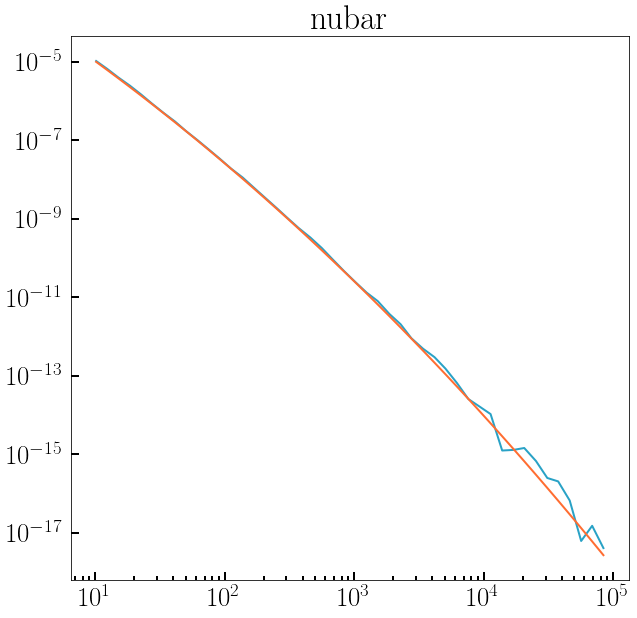

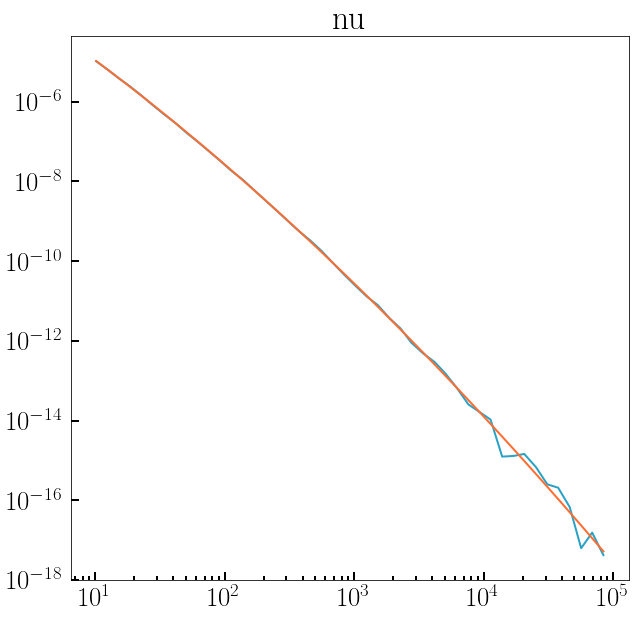

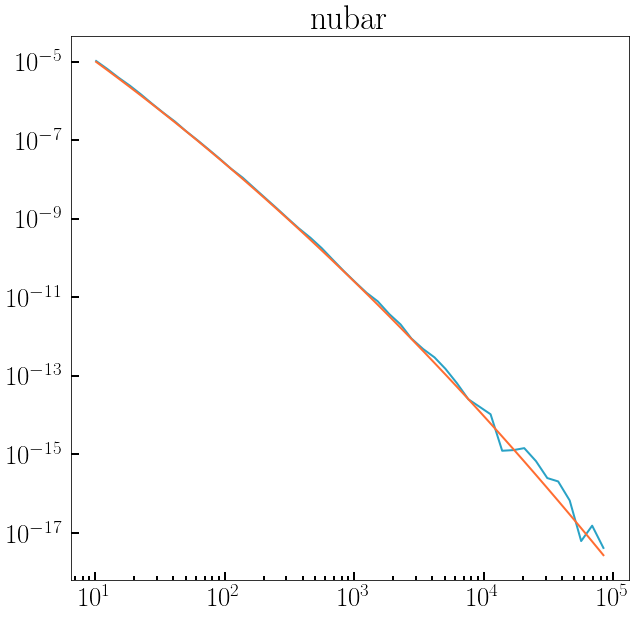

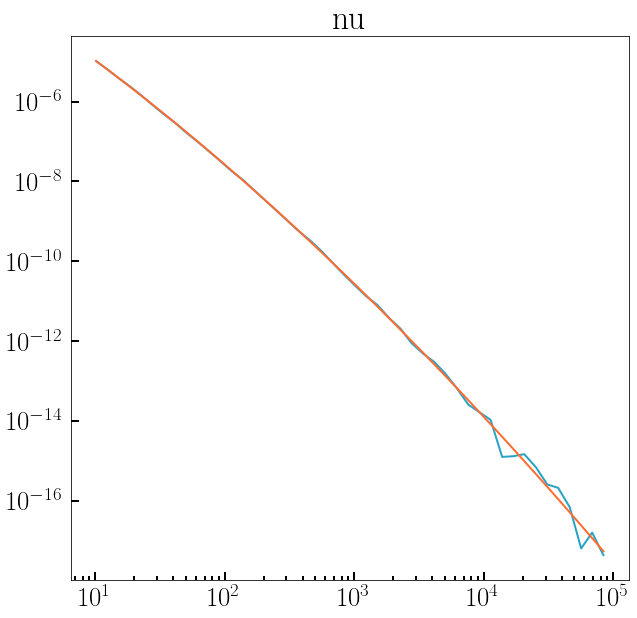

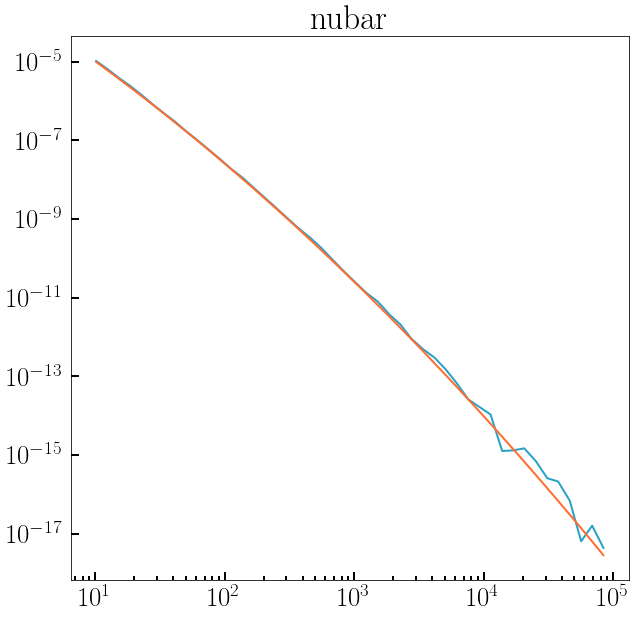

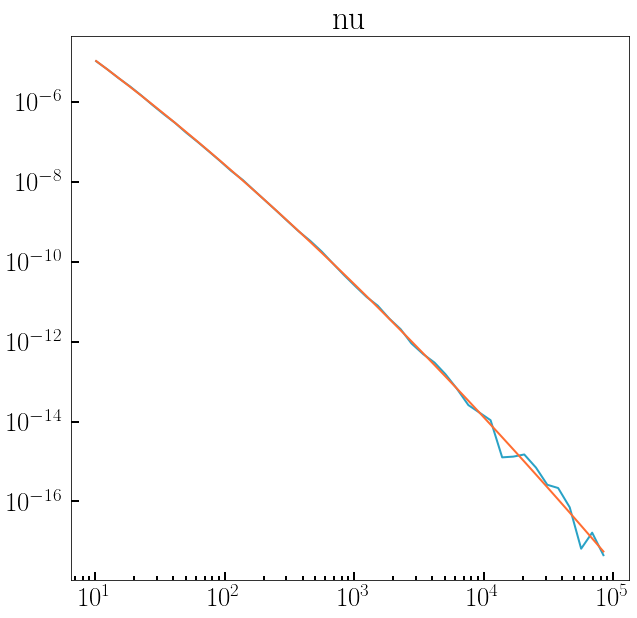

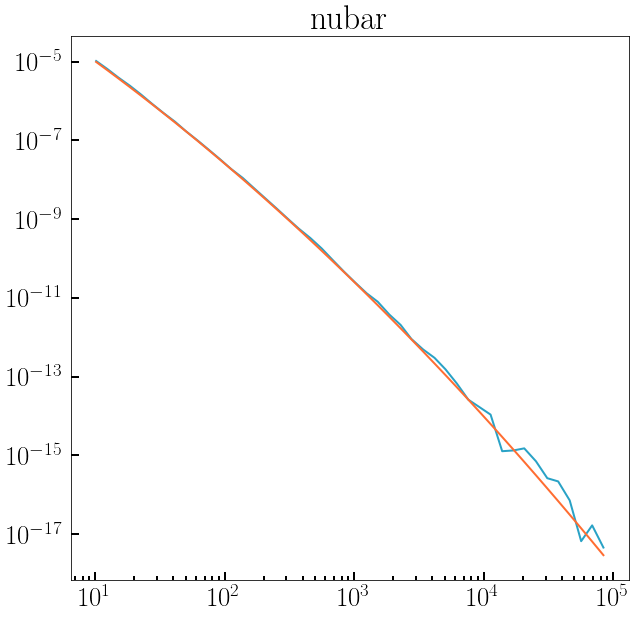

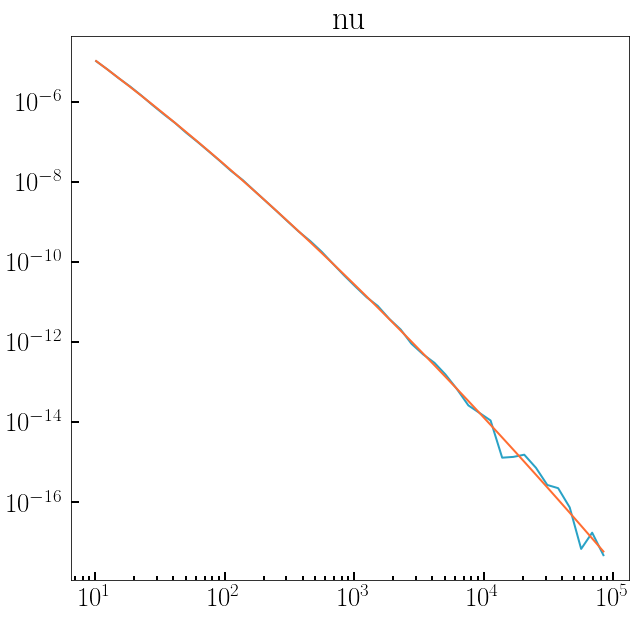

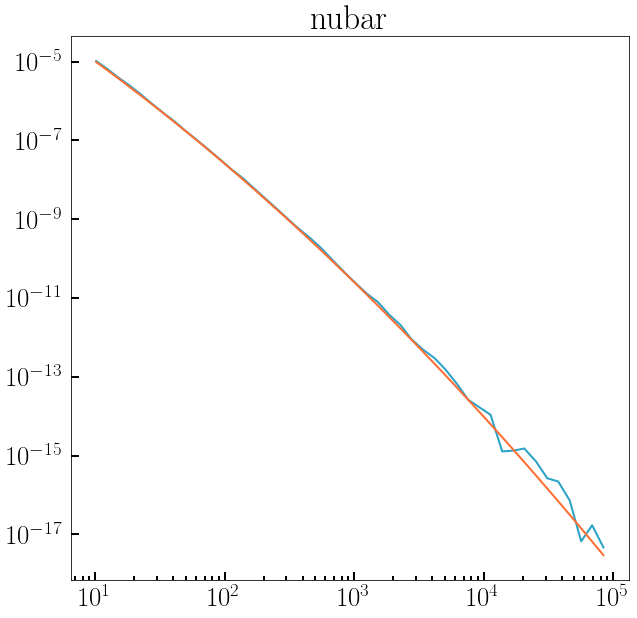

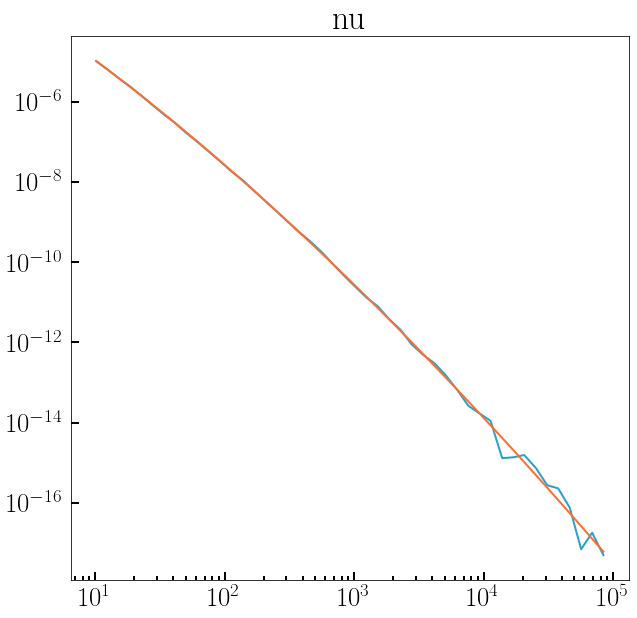

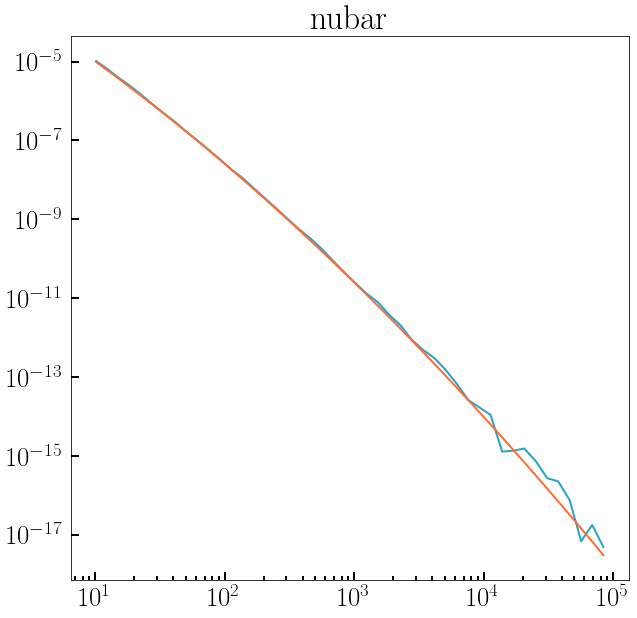

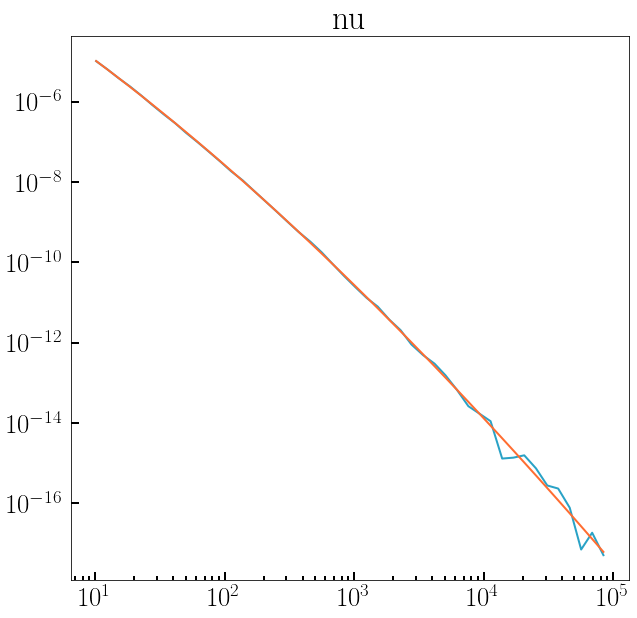

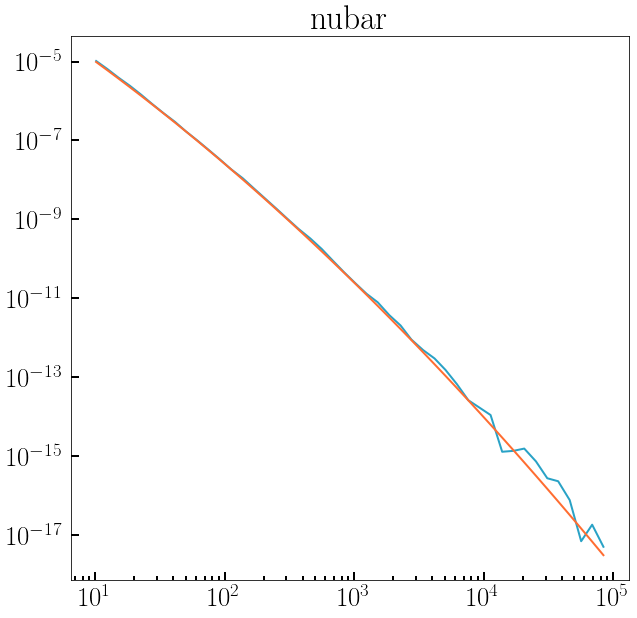

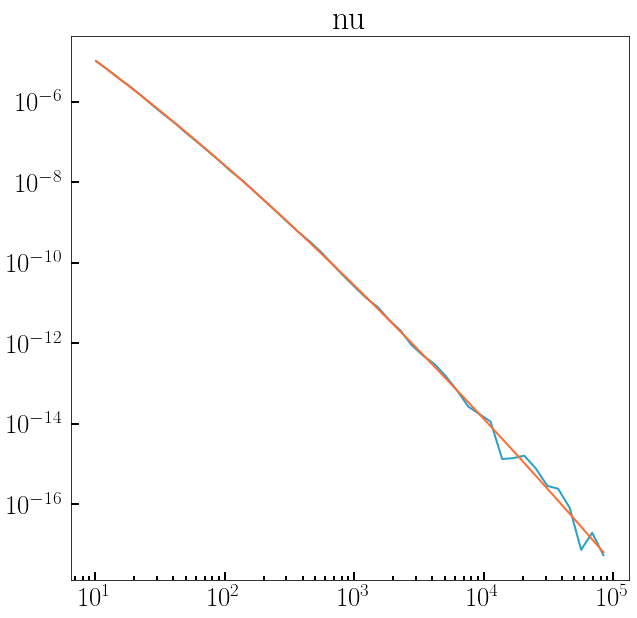

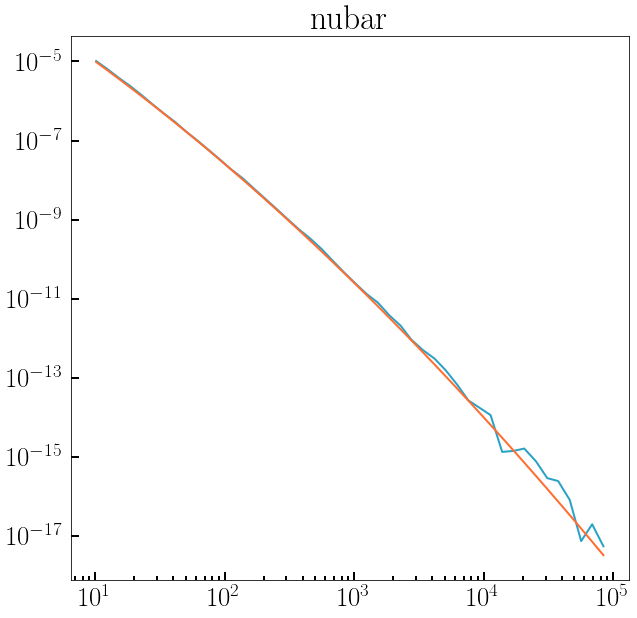

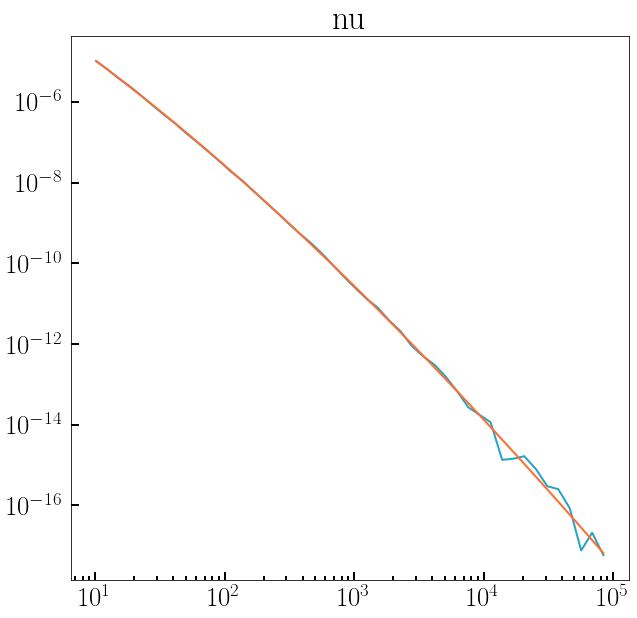

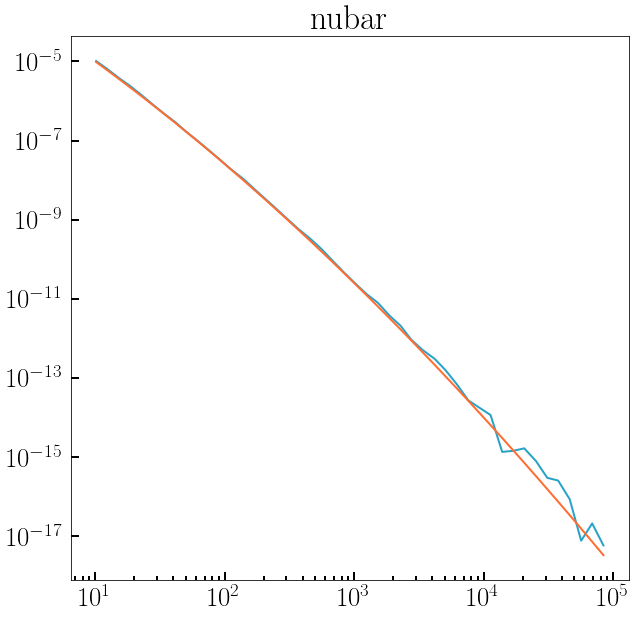

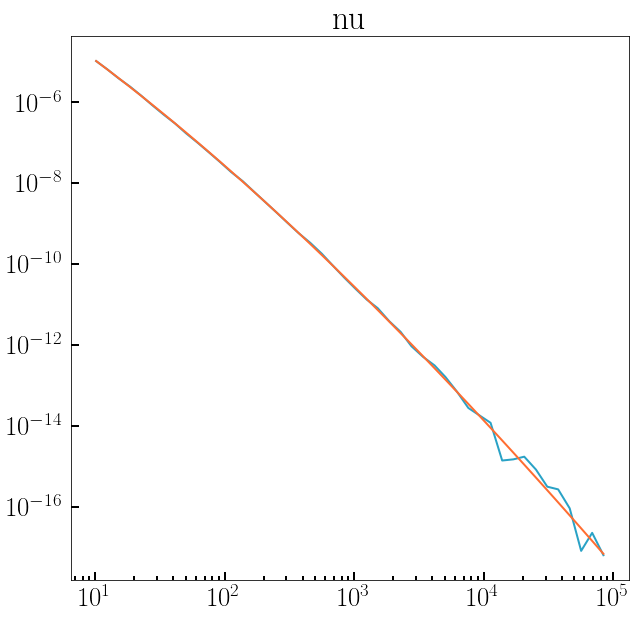

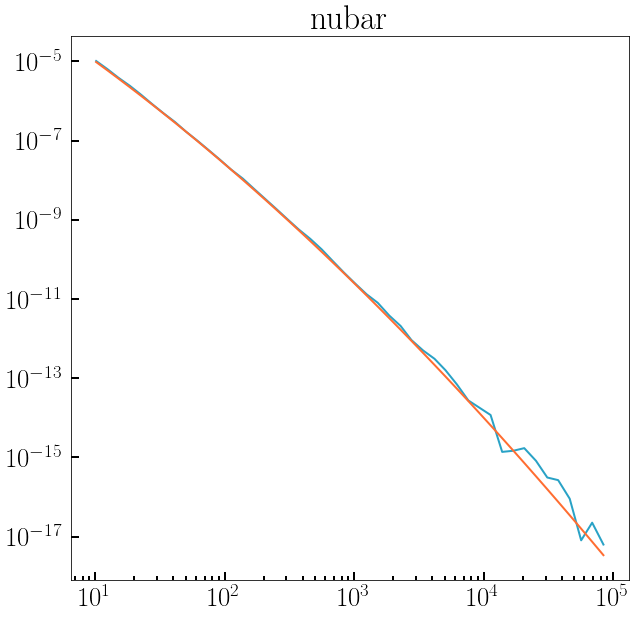

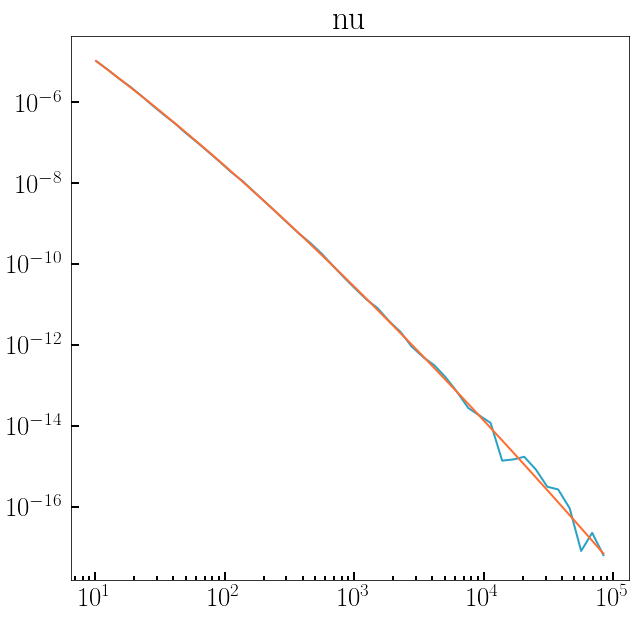

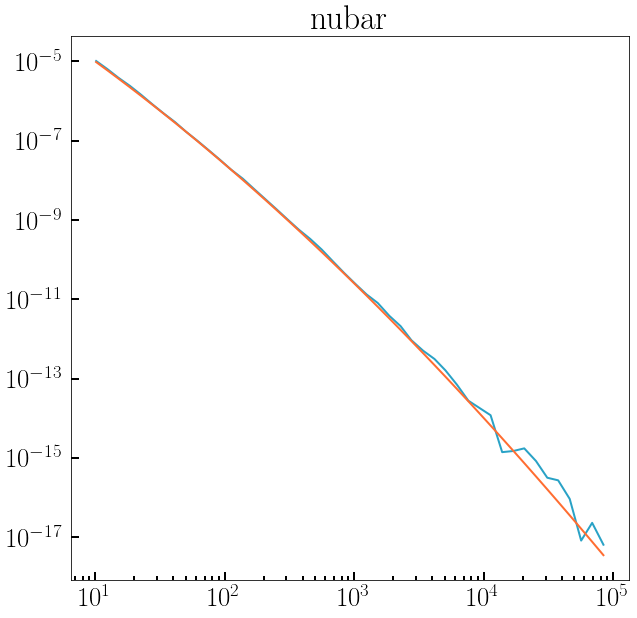

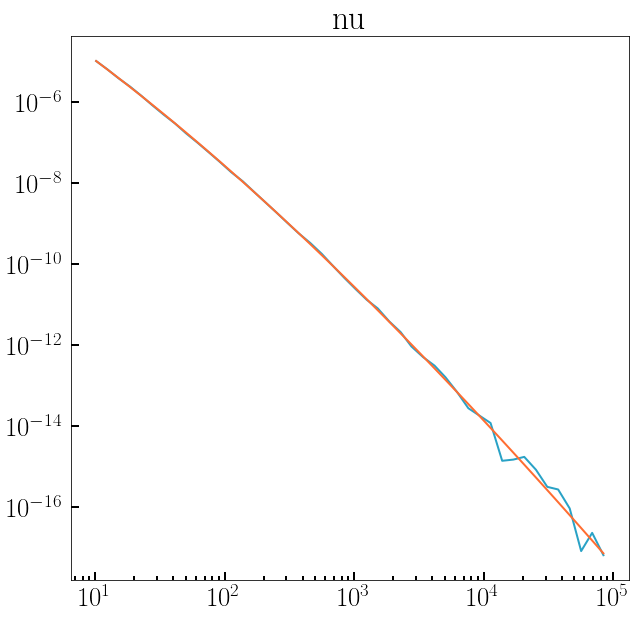

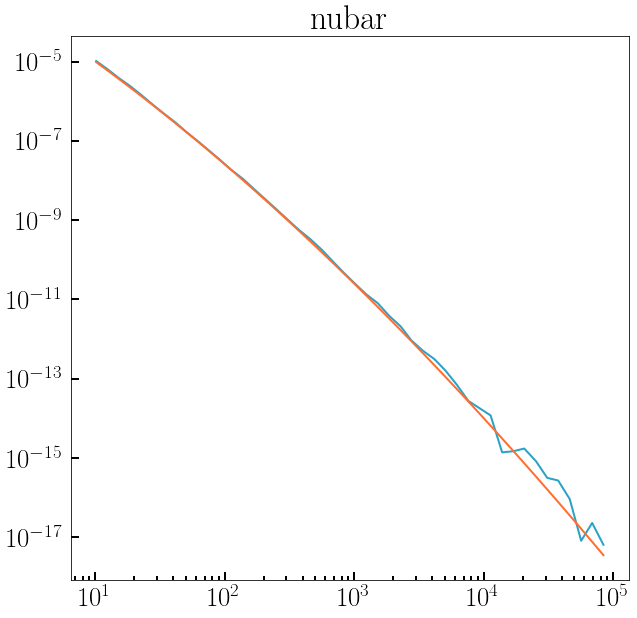

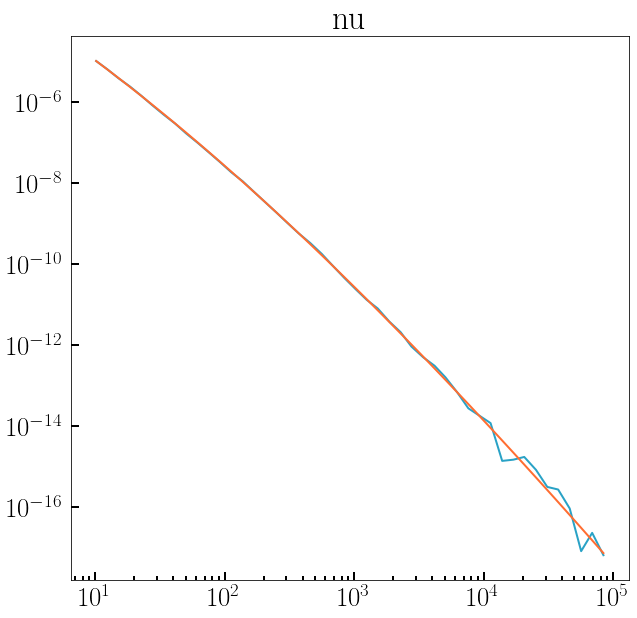

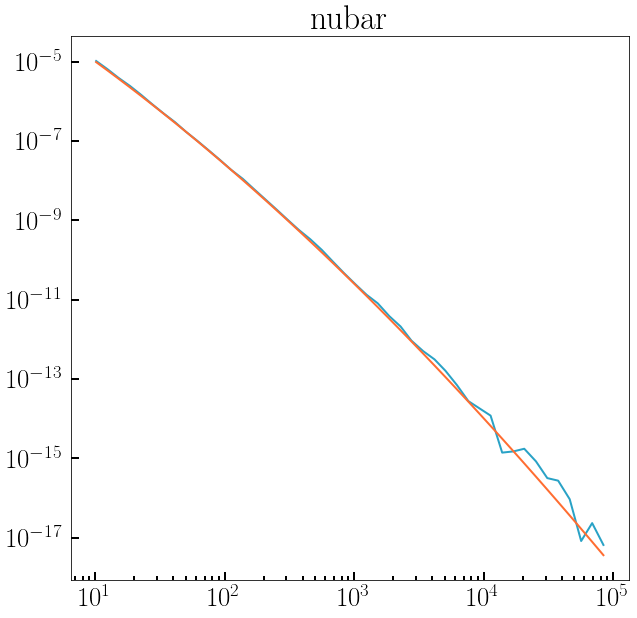

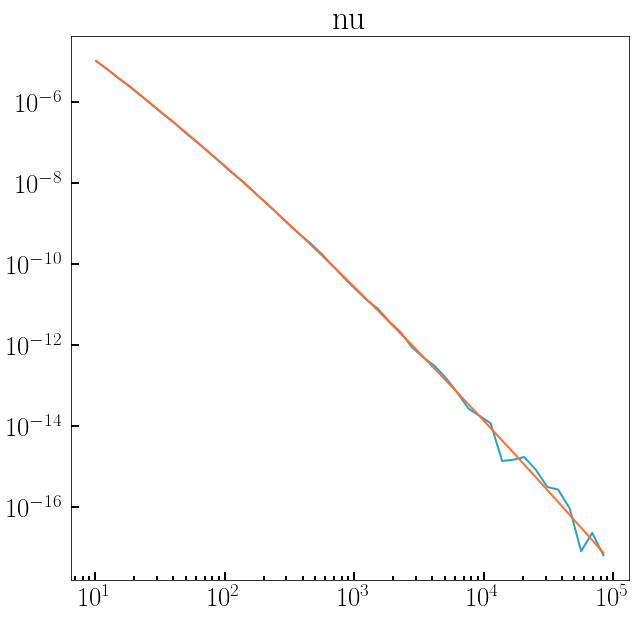

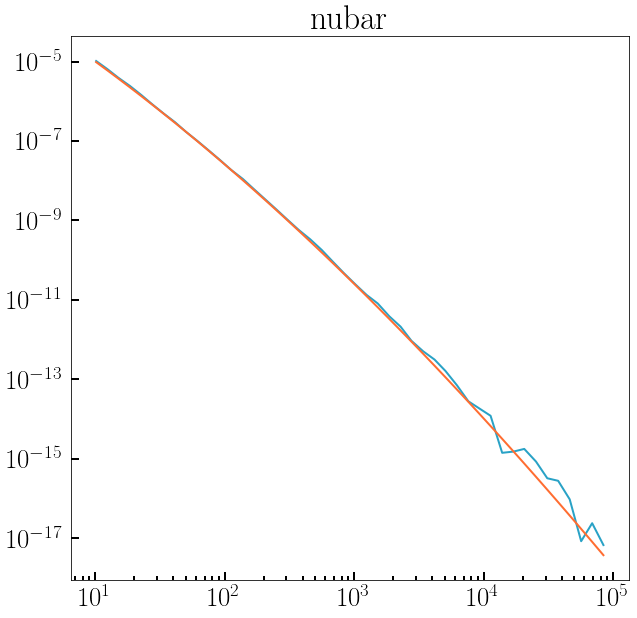

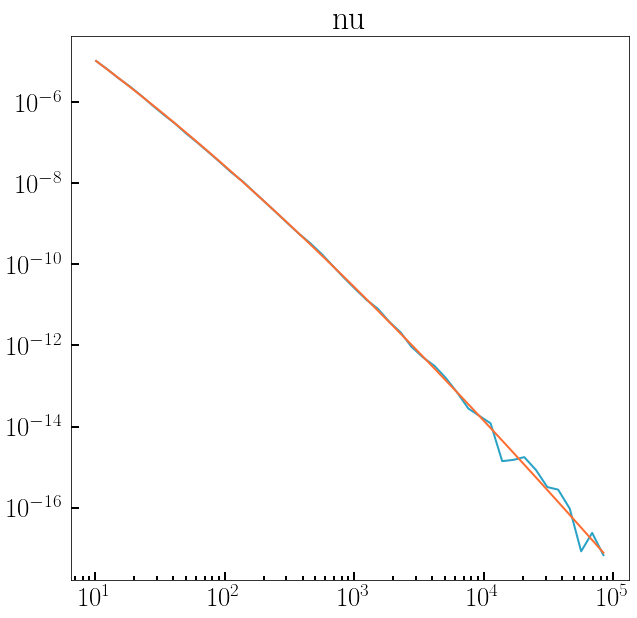

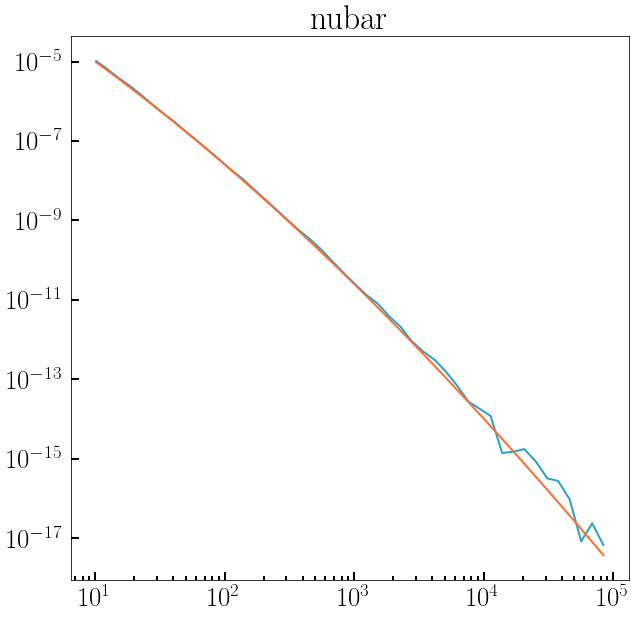

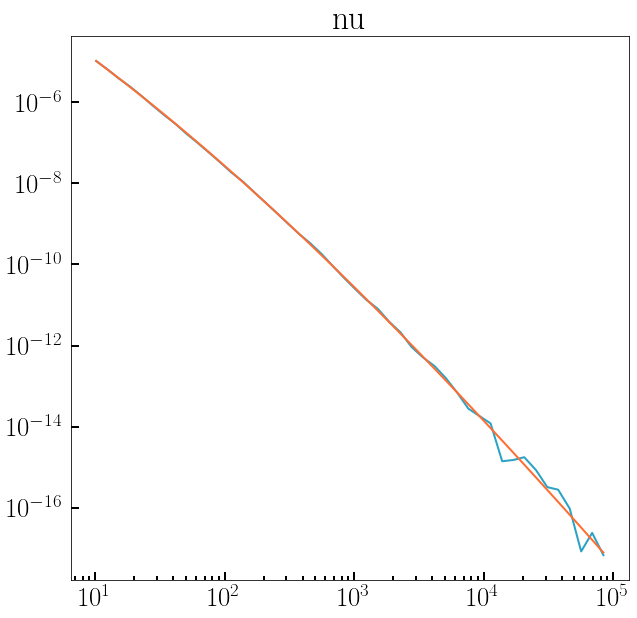

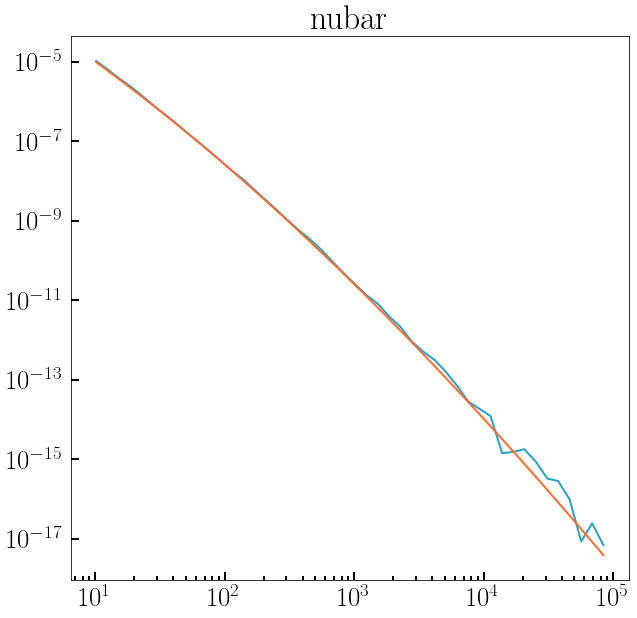

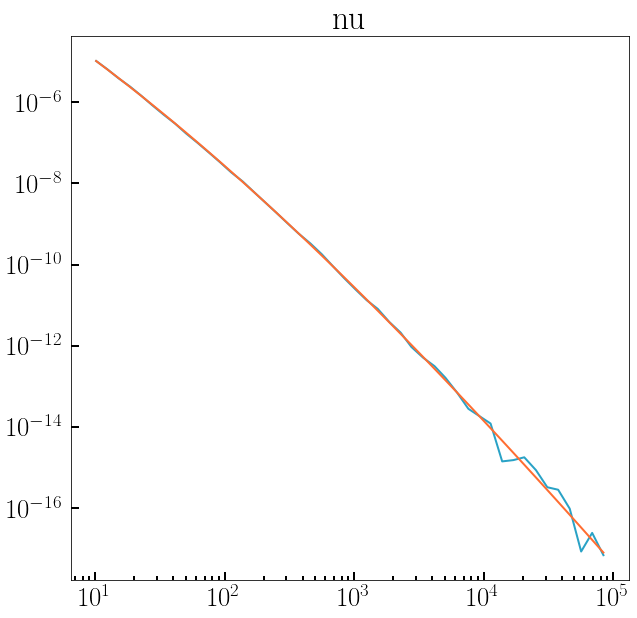

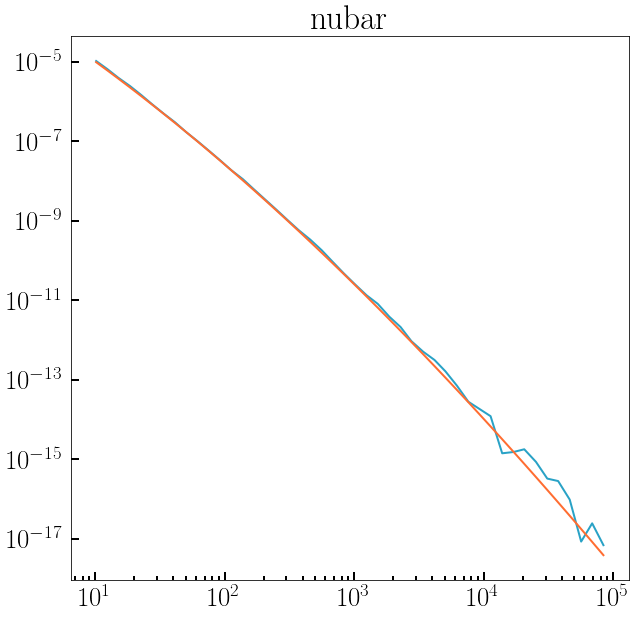

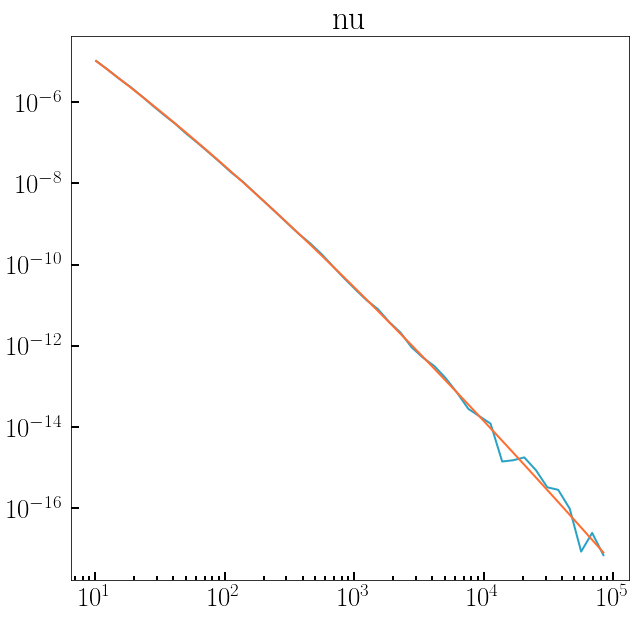

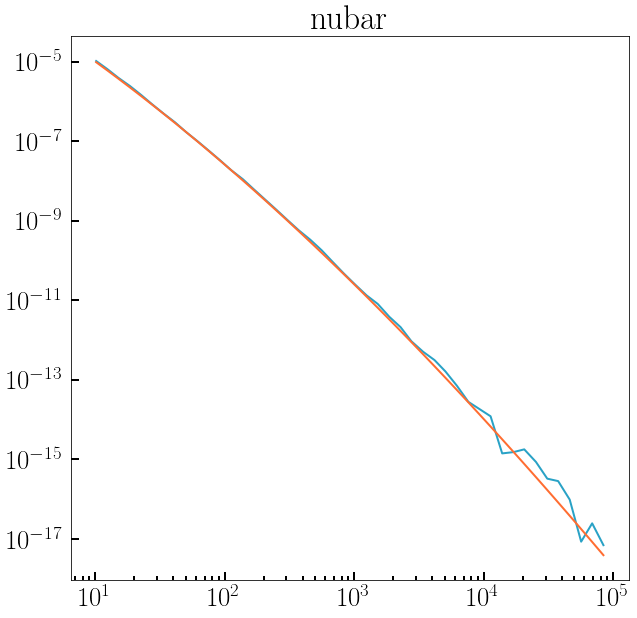

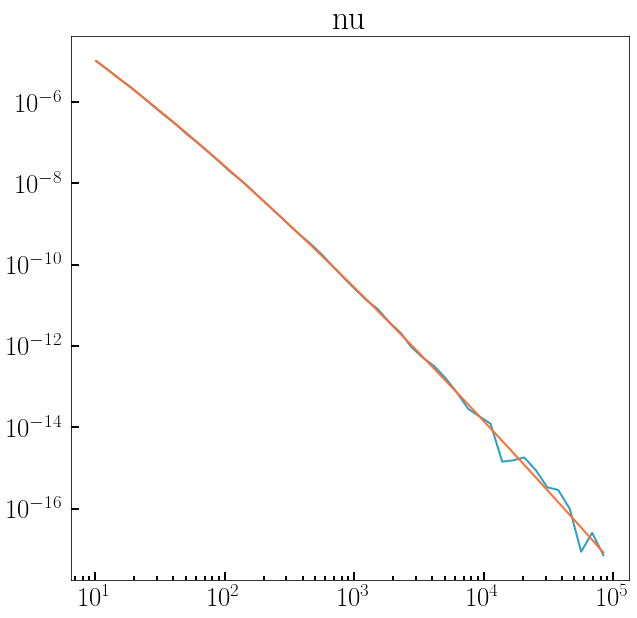

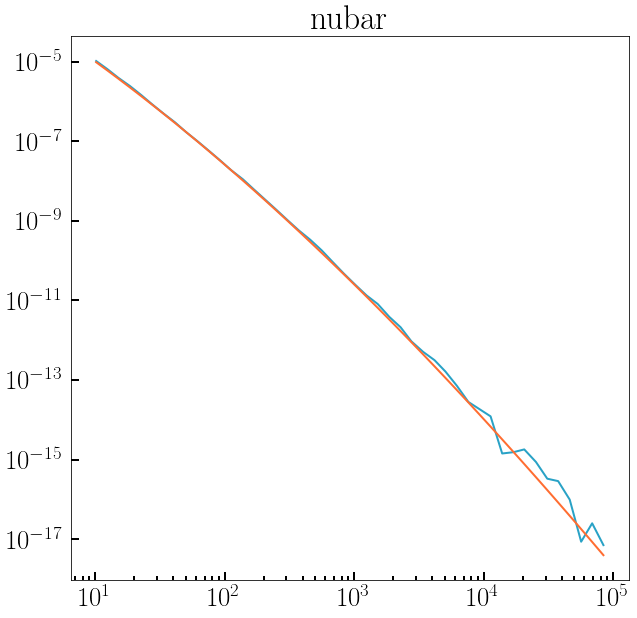

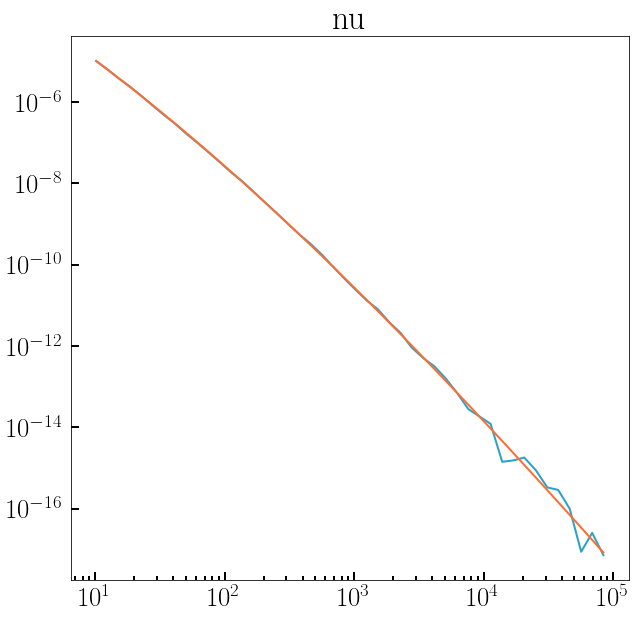

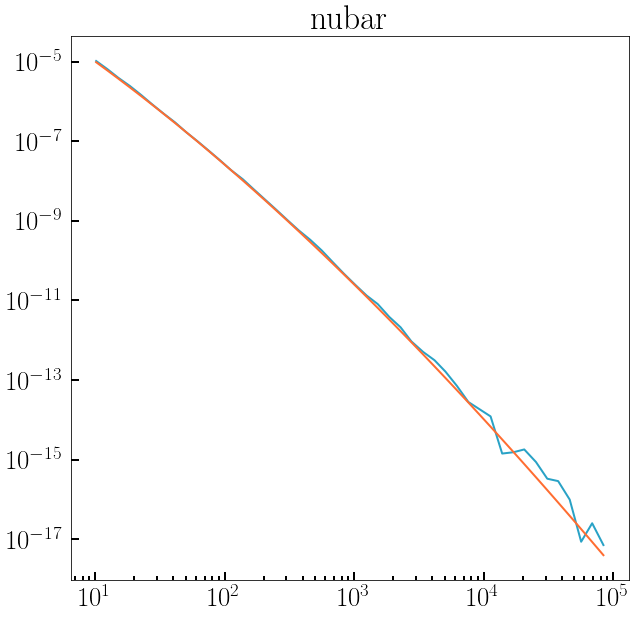

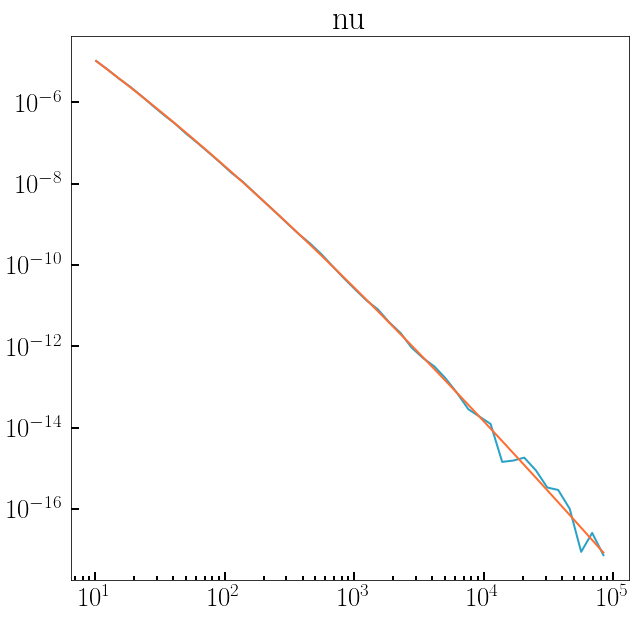

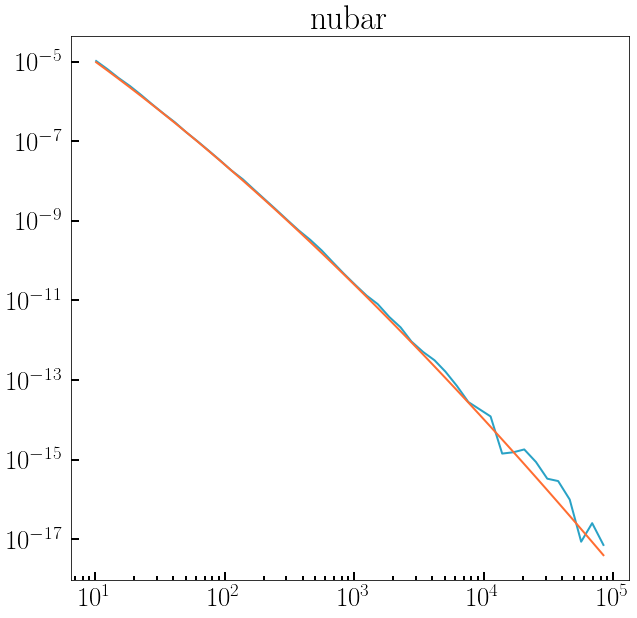

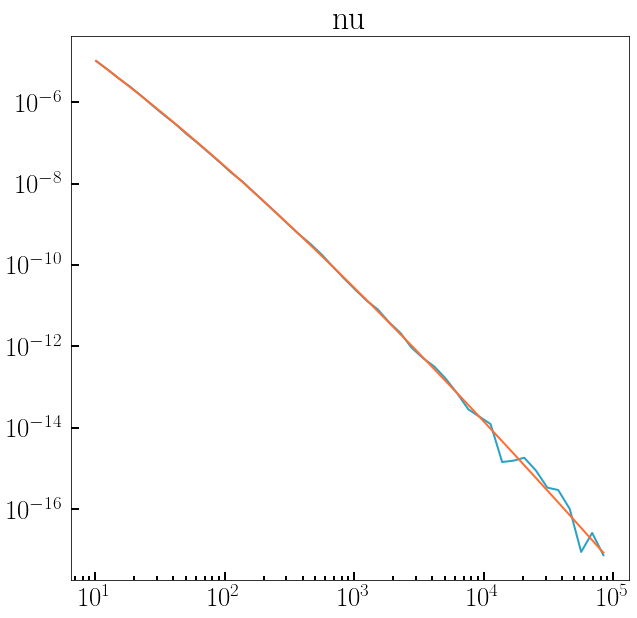

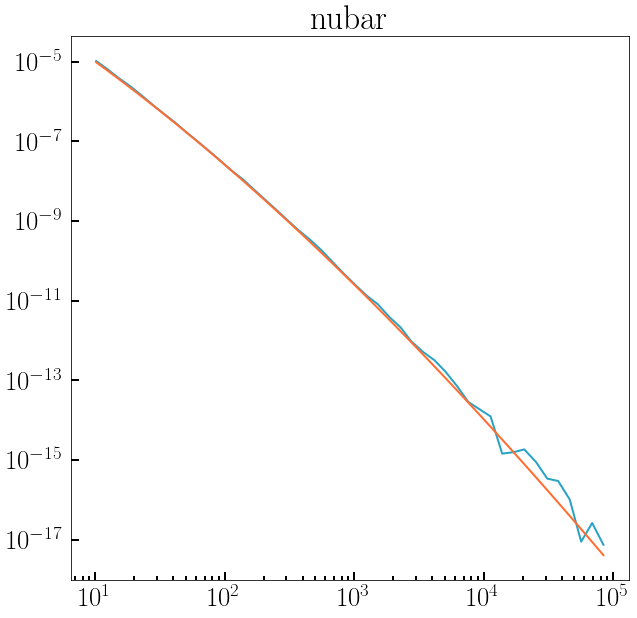

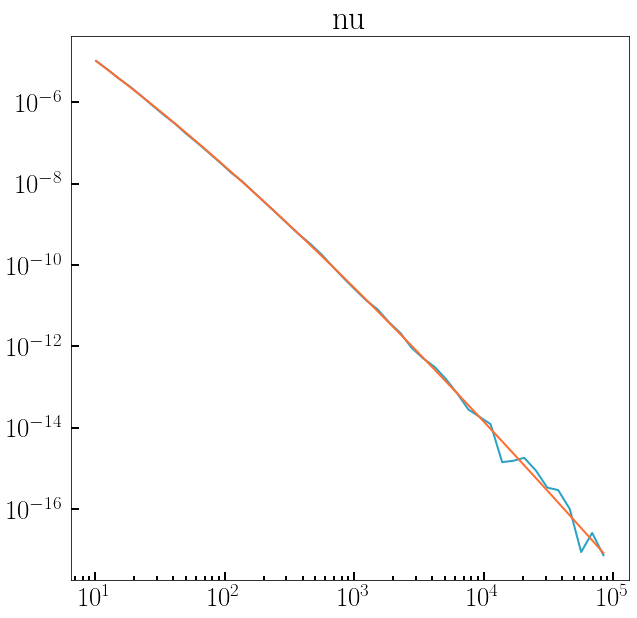

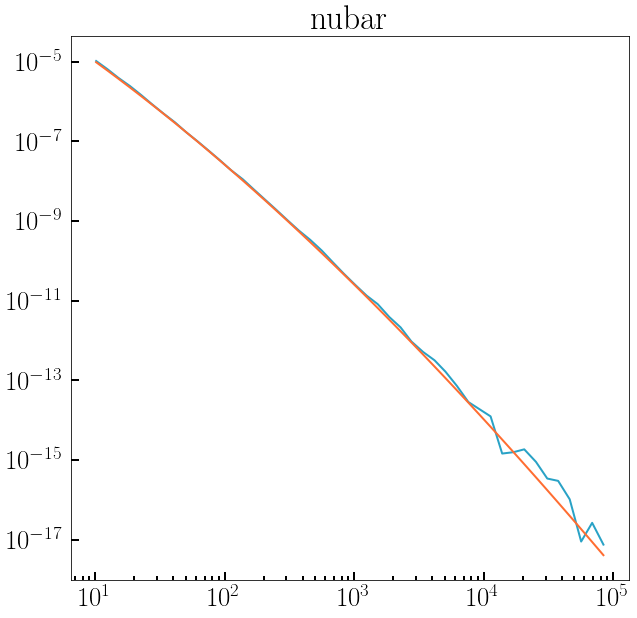

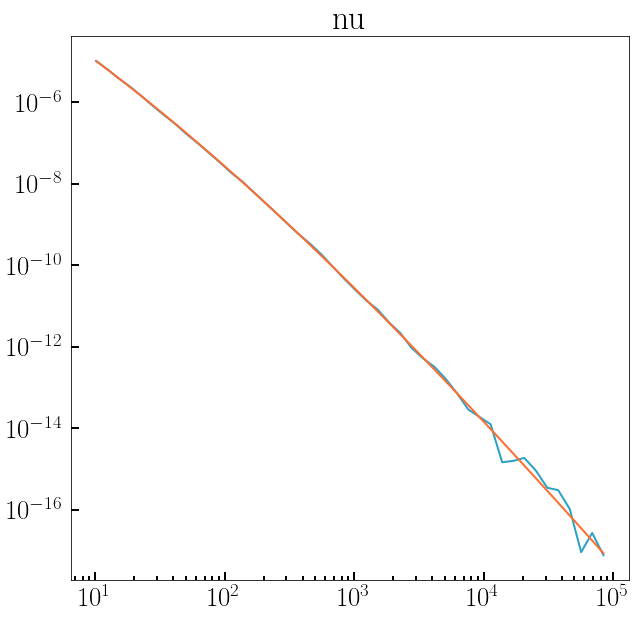

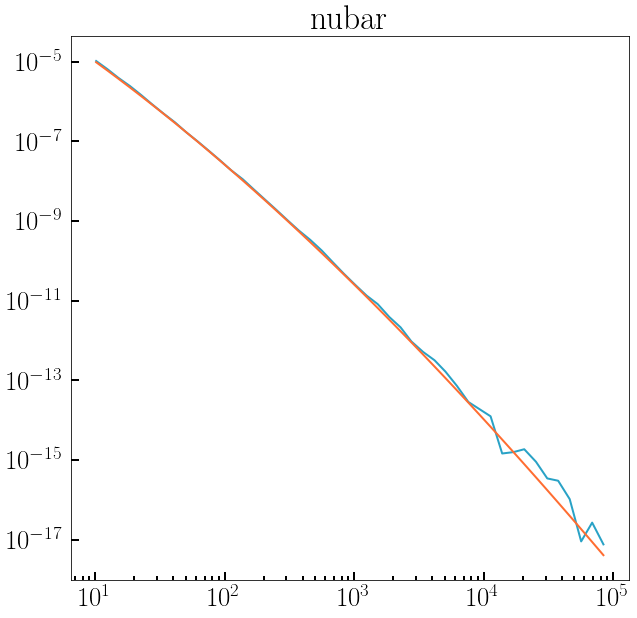

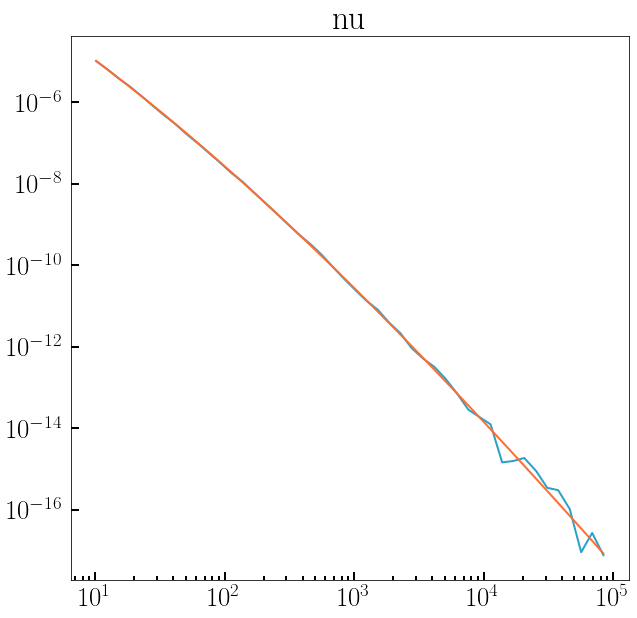

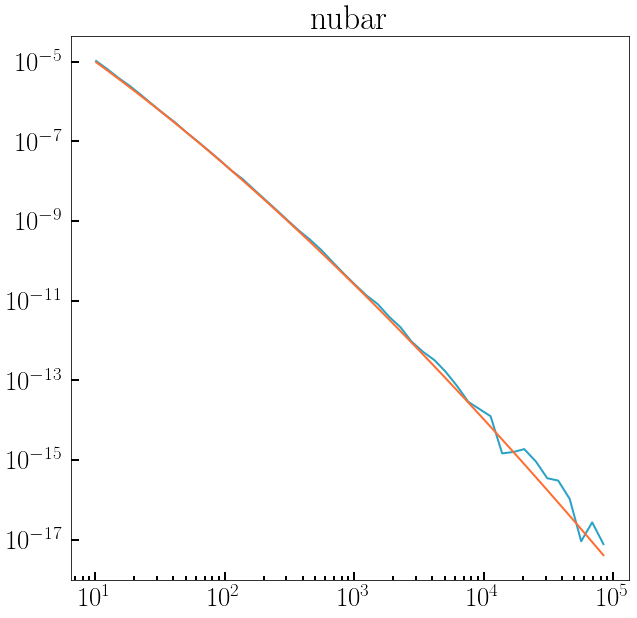

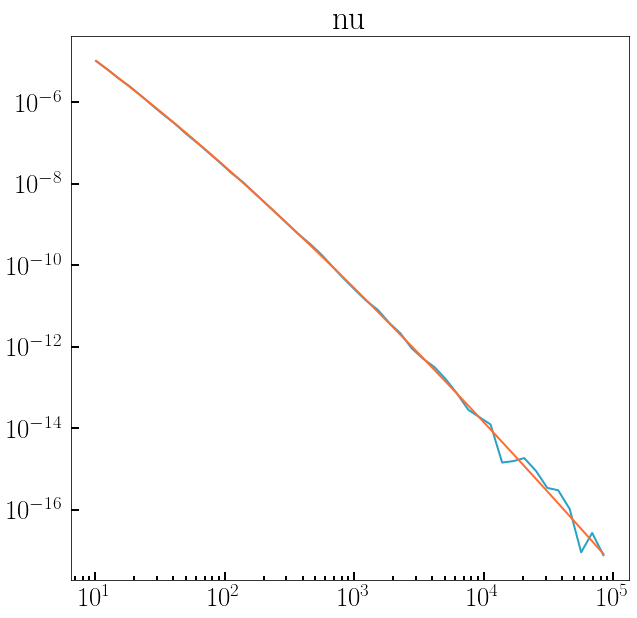

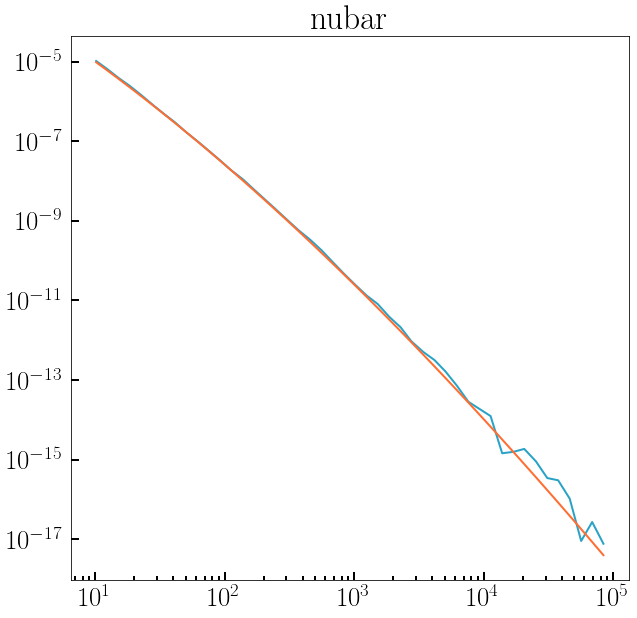

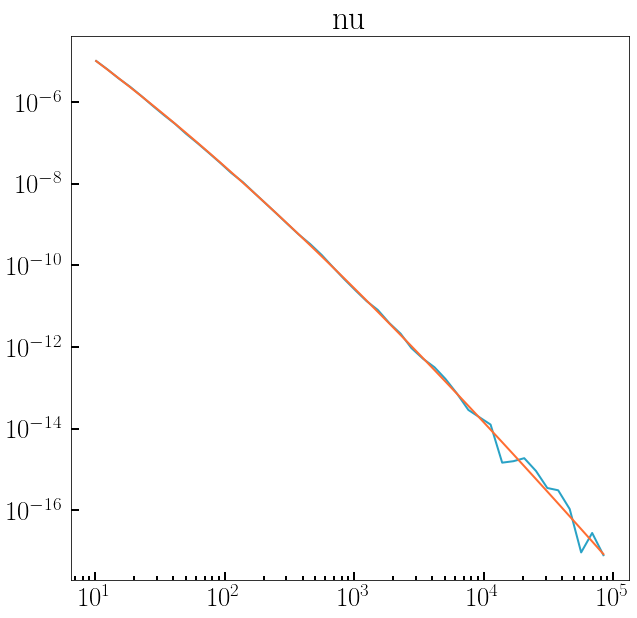

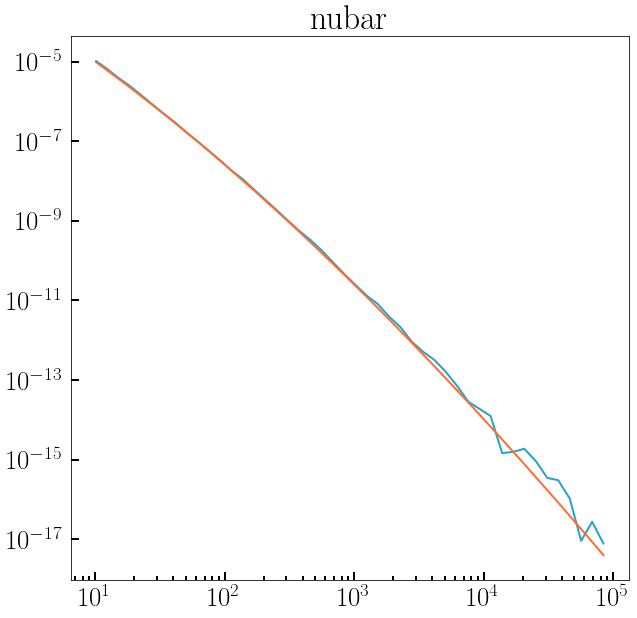

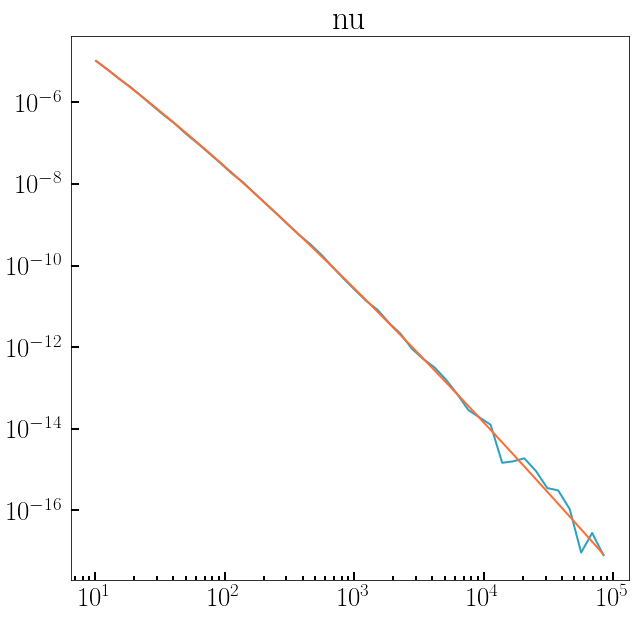

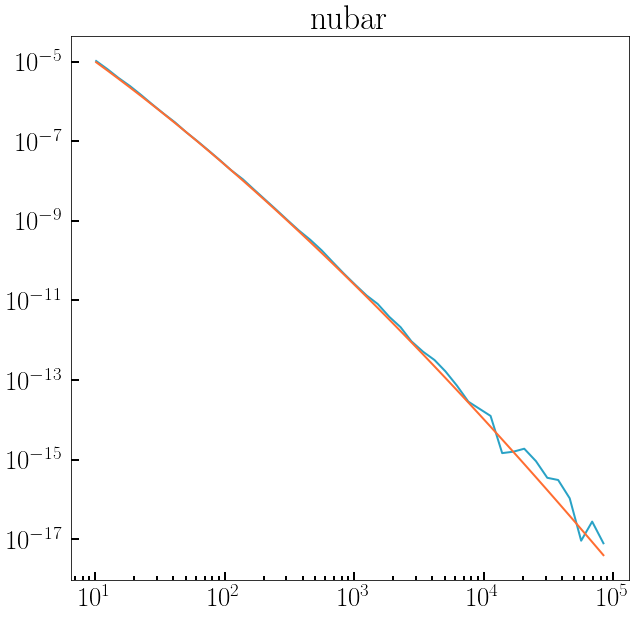

Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
W

Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
W

Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
W

Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
Wrong primary type sucka !
W

ValueError: operands could not be broadcast together with shapes (46,40) (46,50) 

In [90]:
for nu_dist, nubar_dist, cz in zip(solar_detector_flux[:,0,1,:].T, solar_detector_flux[:,1,1,:].T, solar_czens):
    zen = np.arccos(cz+0.05)
    plt.plot(ee, nu_dist)
    plt.plot(ee, [get_flux(e, zen, 14) for e in ee])
    plt.loglog()
    plt.title('nu')
    plt.show()
    plt.plot(ee, nubar_dist)
    plt.plot(ee, [get_flux(e, zen, -14) for e in ee])
    plt.loglog()
    plt.title('nubar')
    plt.show()

nu_check = np.array([[get_flux(e, np.arccos(cz), 14) for e in ee] for cz in czens]).T
plt.imshow(np.divide(detector_flux[:,0,1,:], nu_check))
plt.colorbar()
plt.show()

nubar_check = np.array([[get_flux(e, np.arccos(cz), -14) for e in ee] for cz in czens]).T
plt.imshow(np.divide(detector_flux[:,1,1,:], nubar_check))
plt.colorbar()
plt.show()

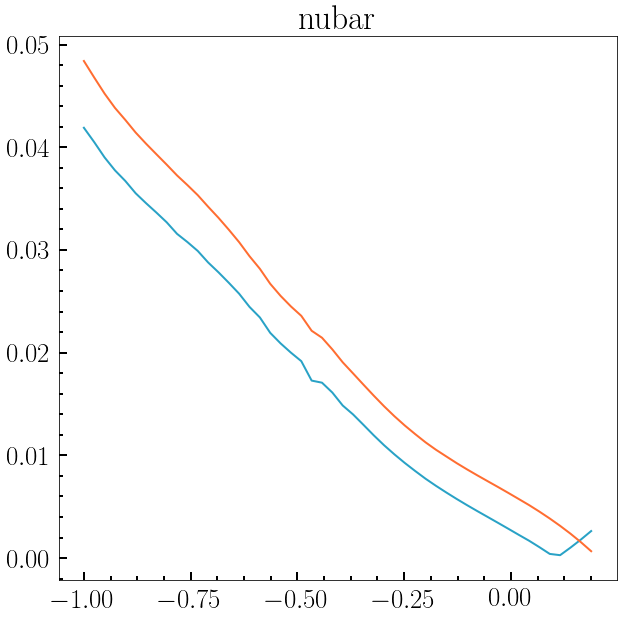

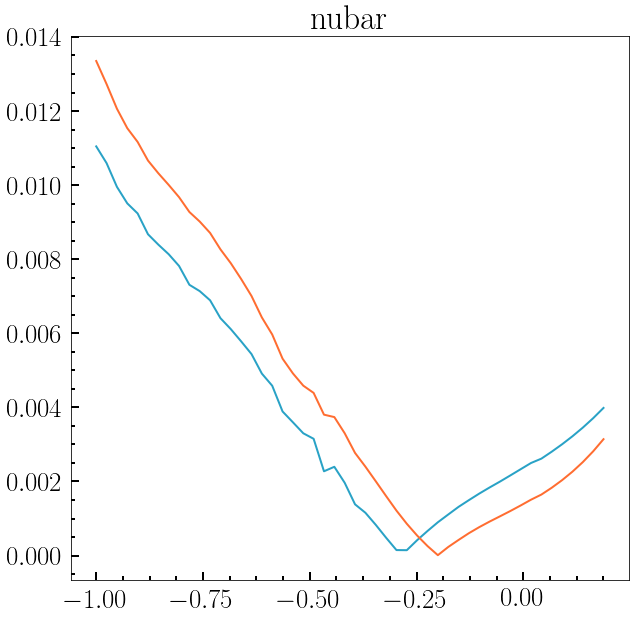

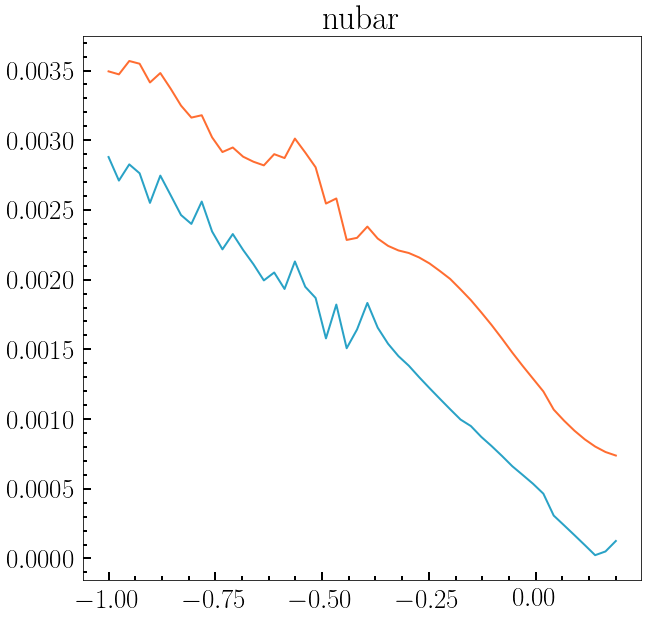

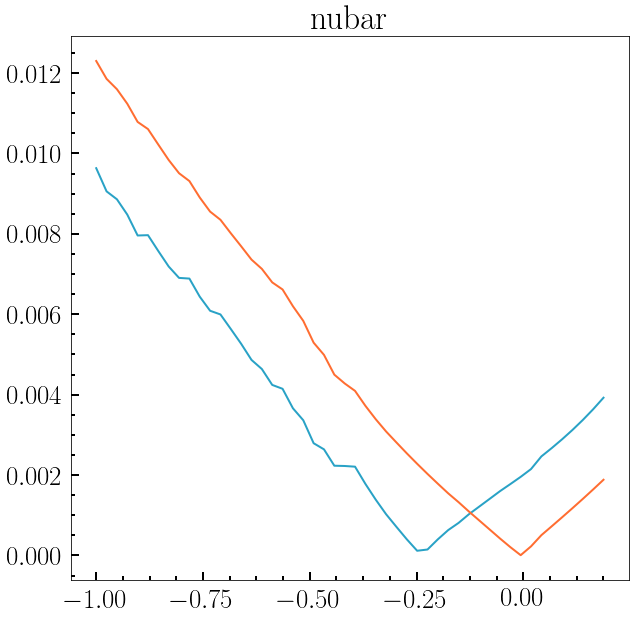

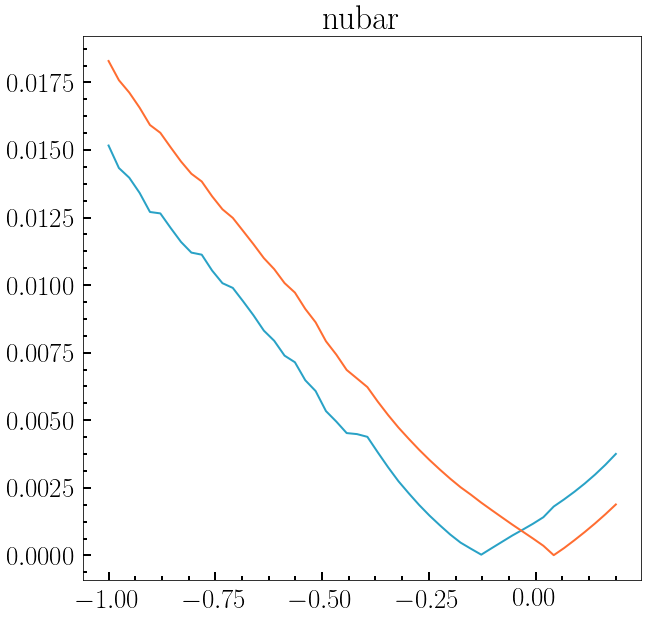

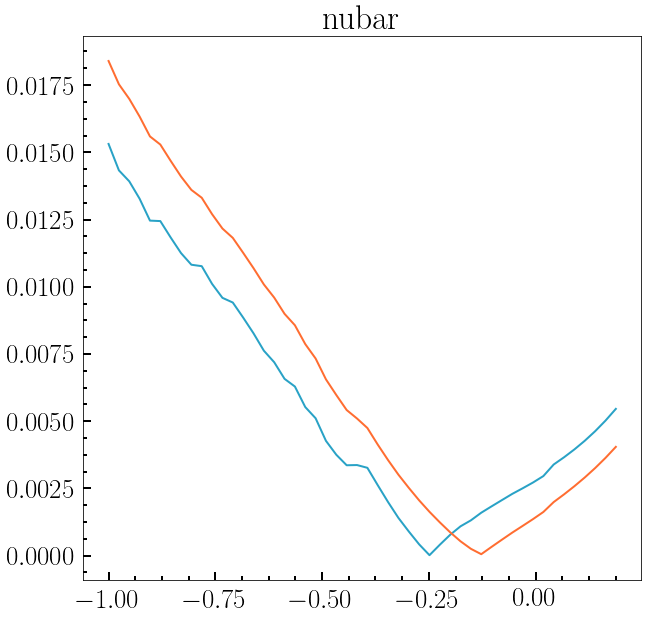

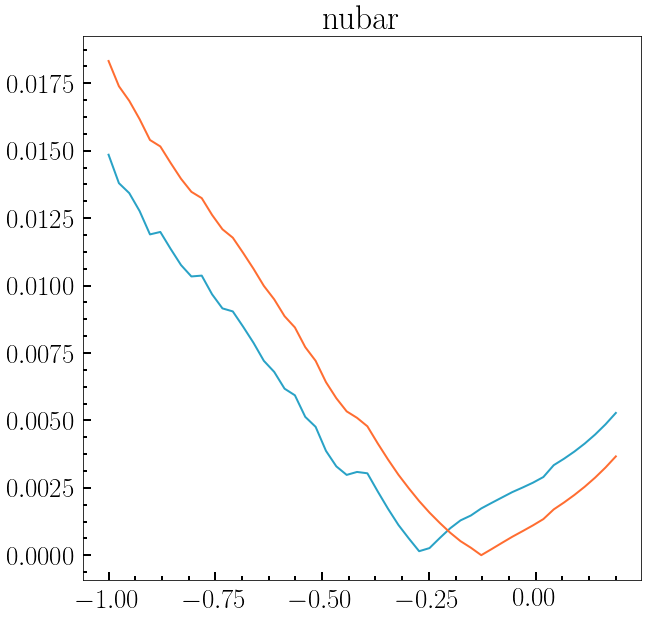

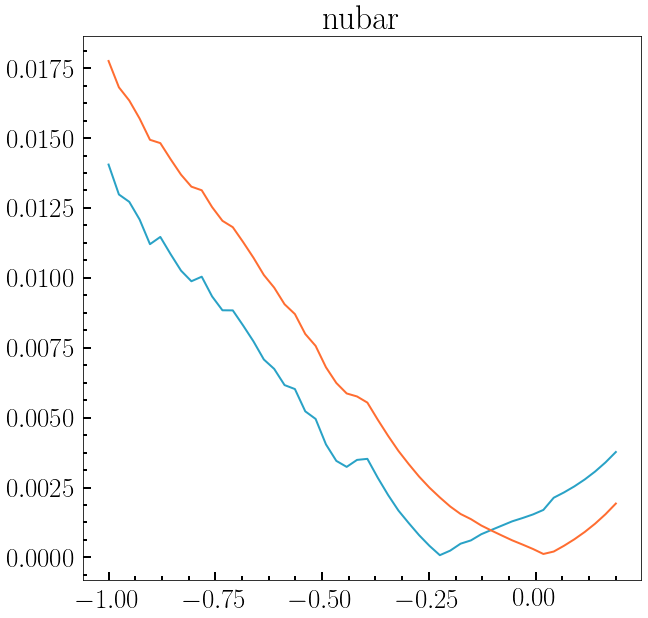

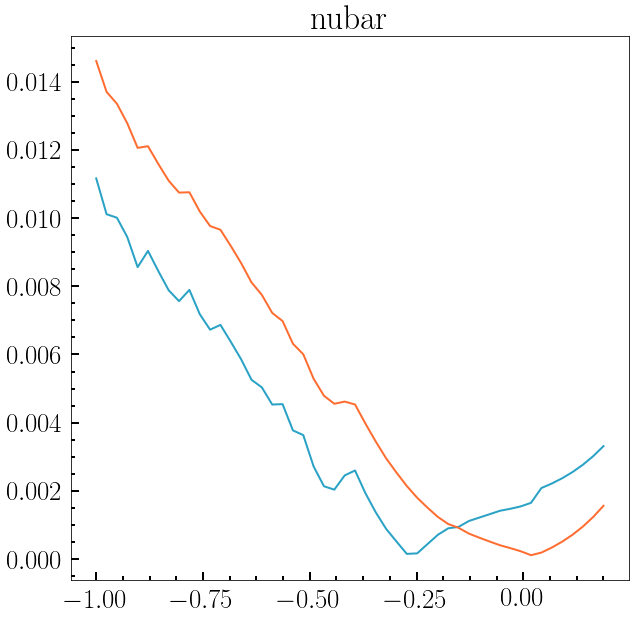

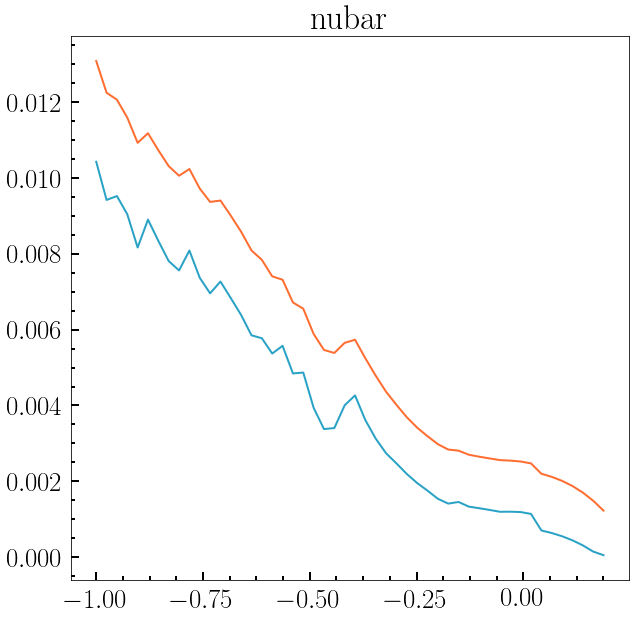

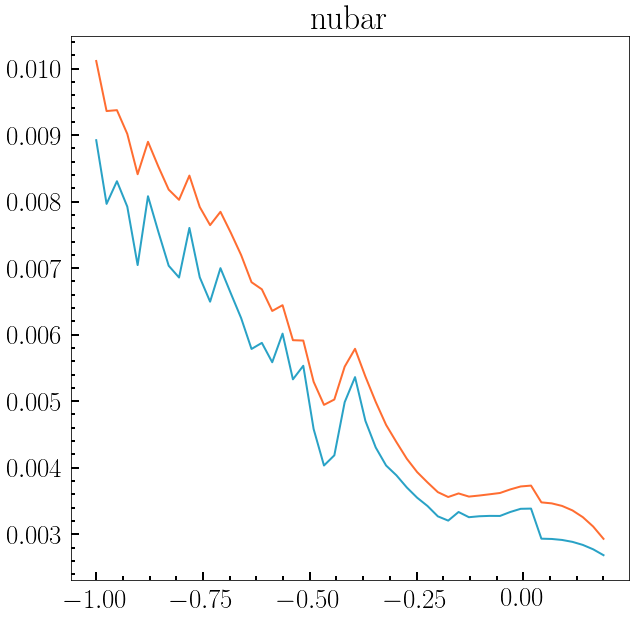

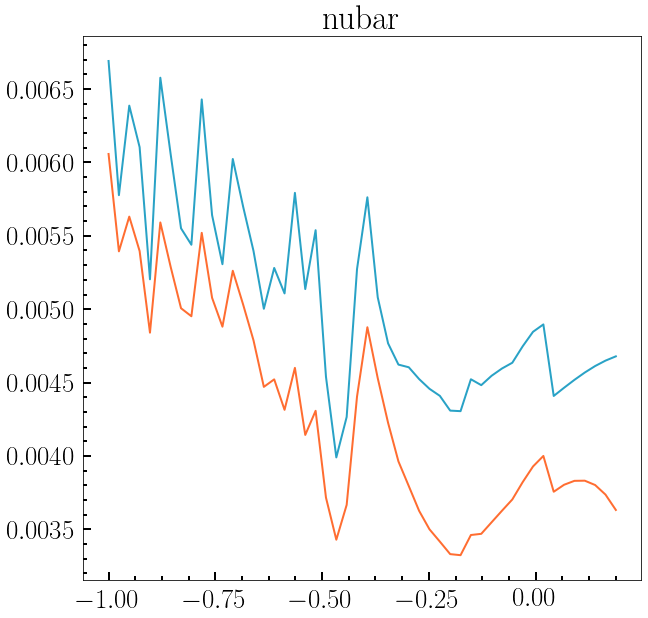

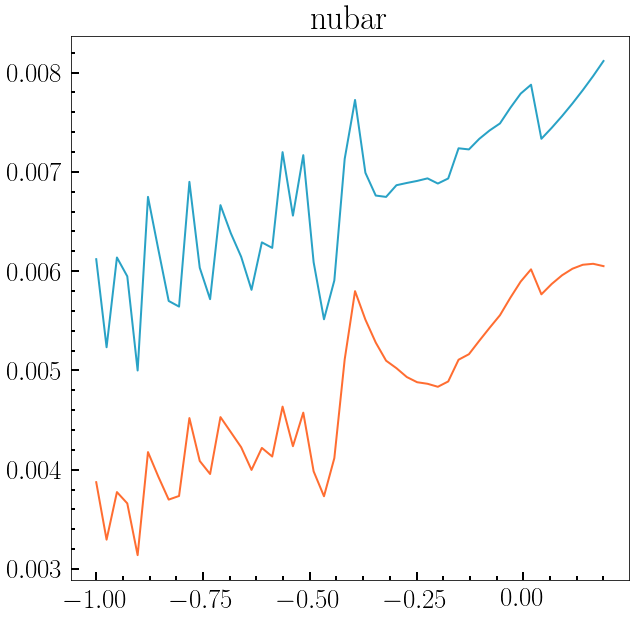

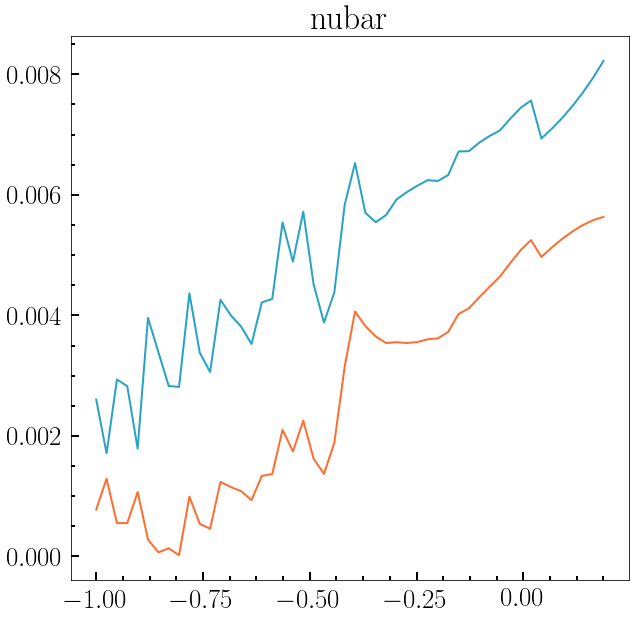

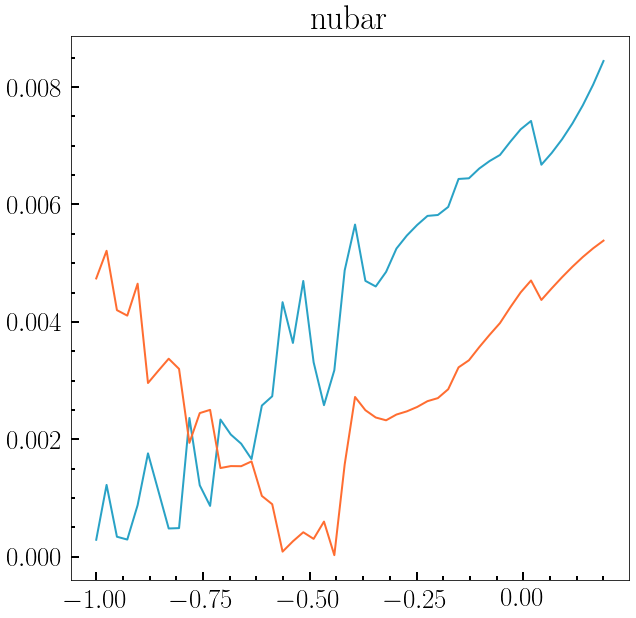

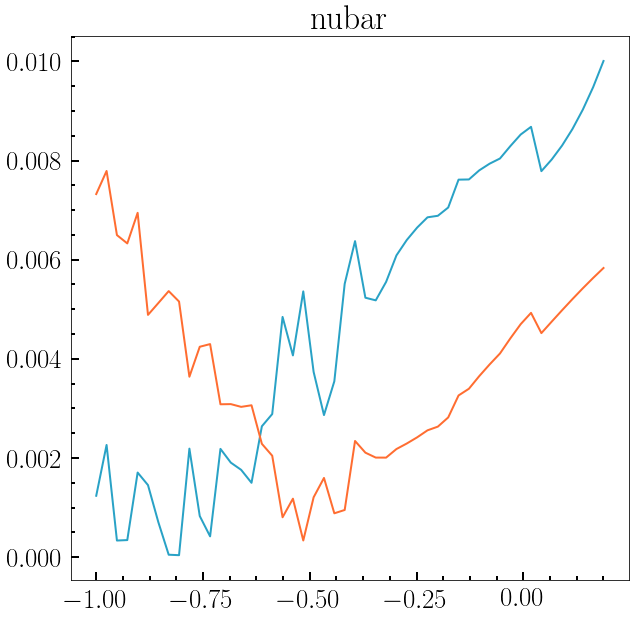

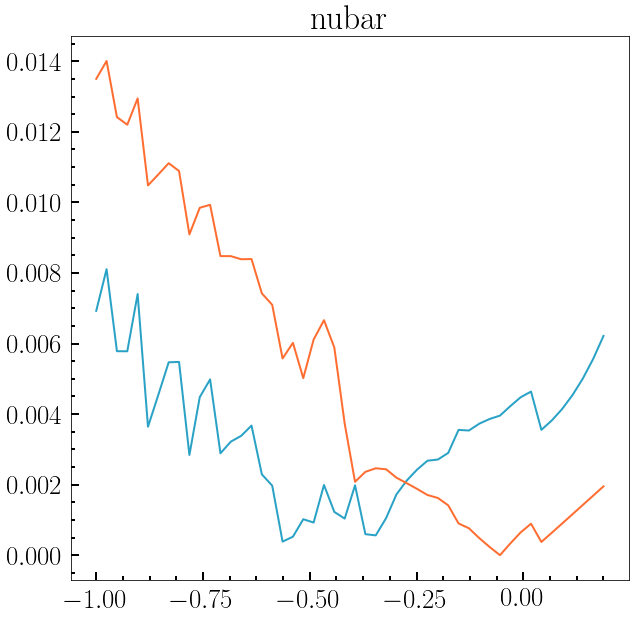

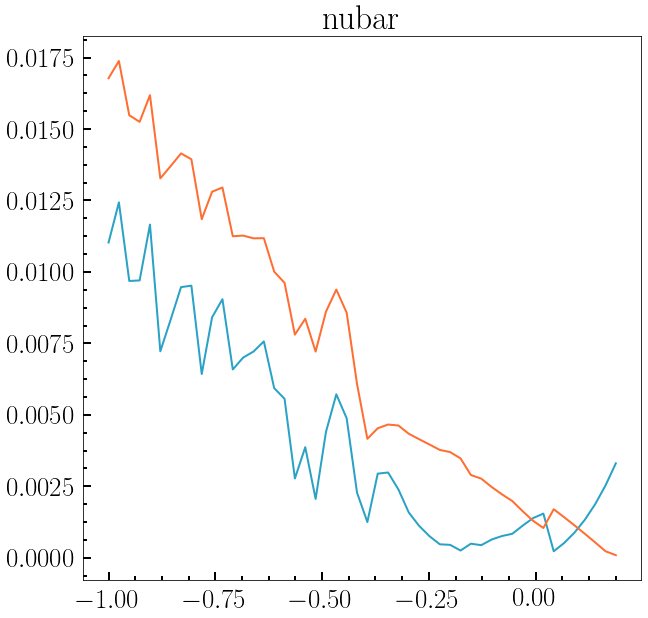

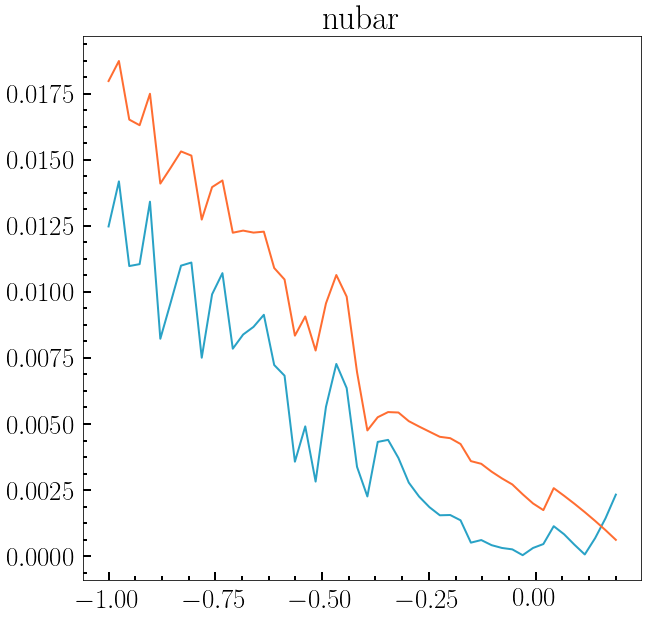

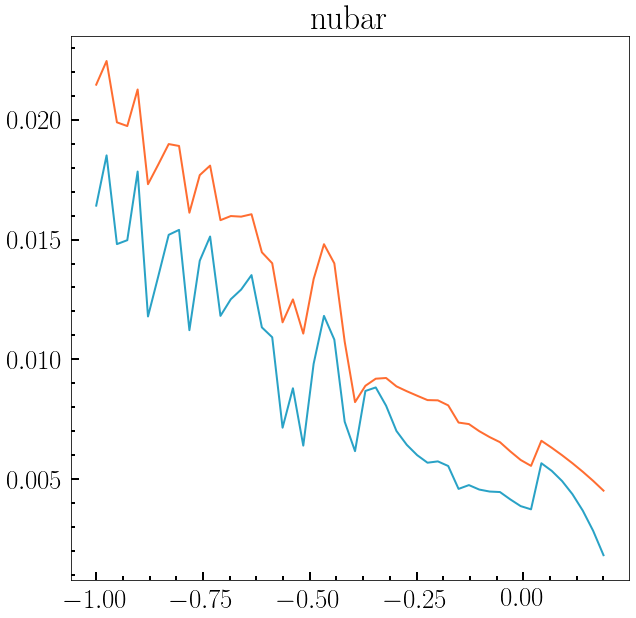

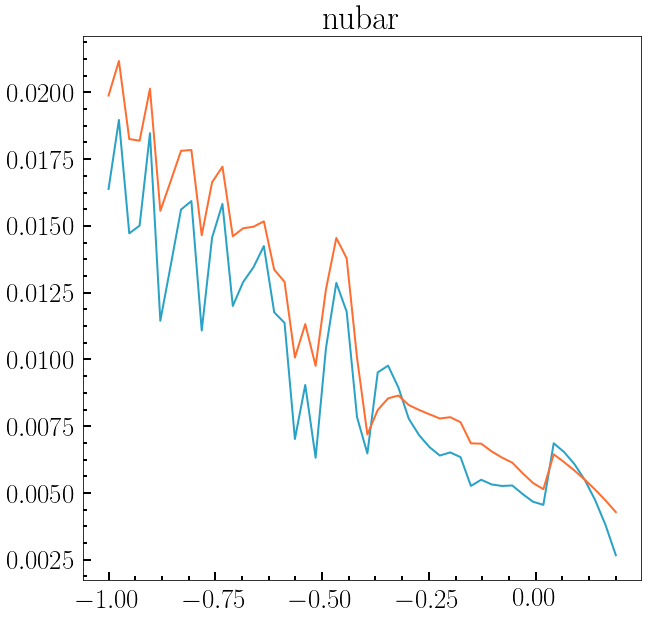

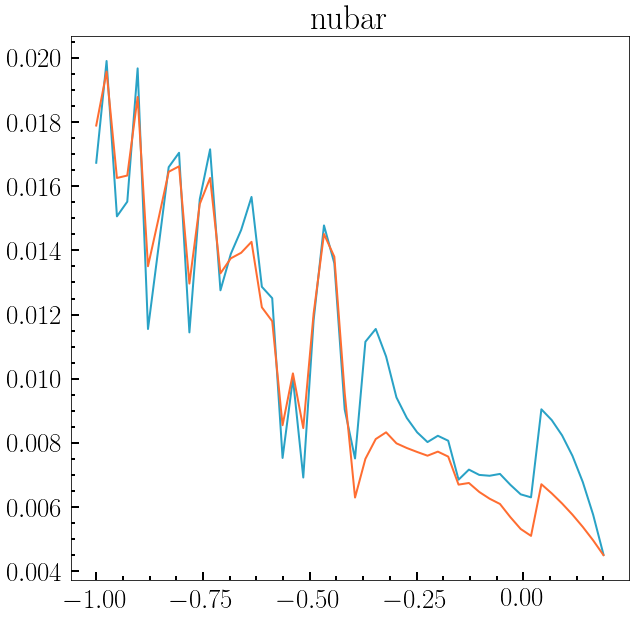

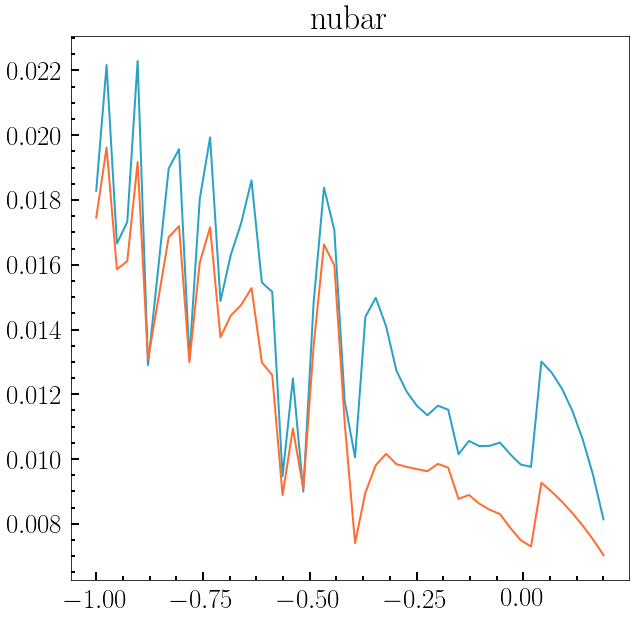

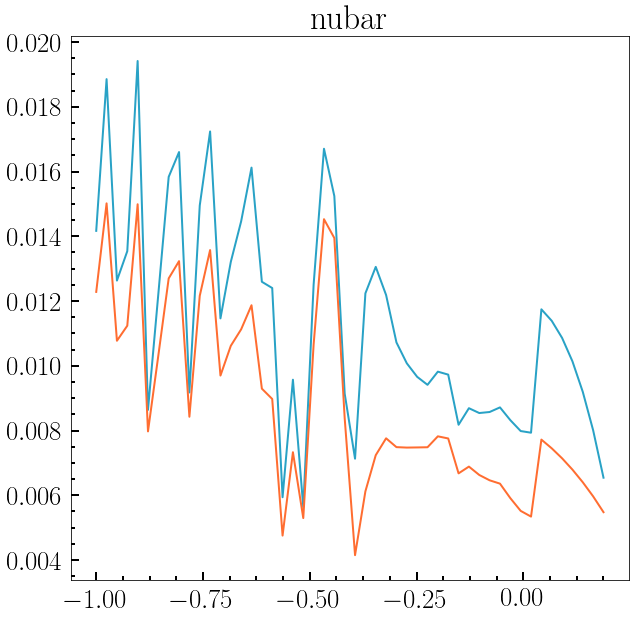

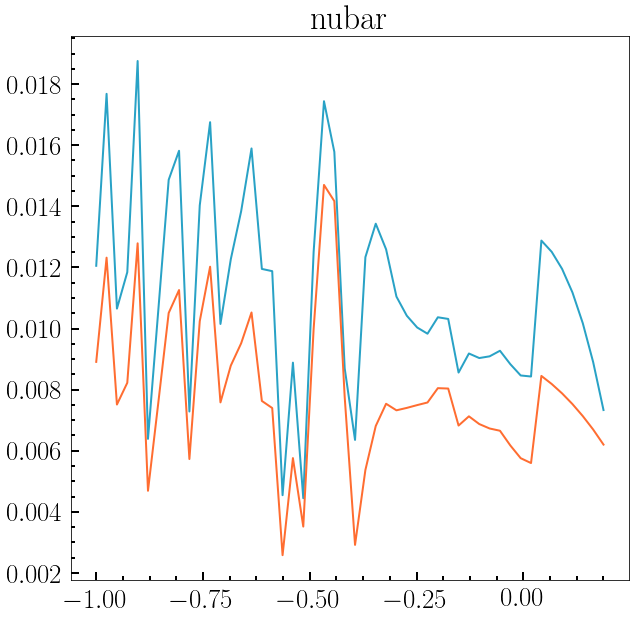

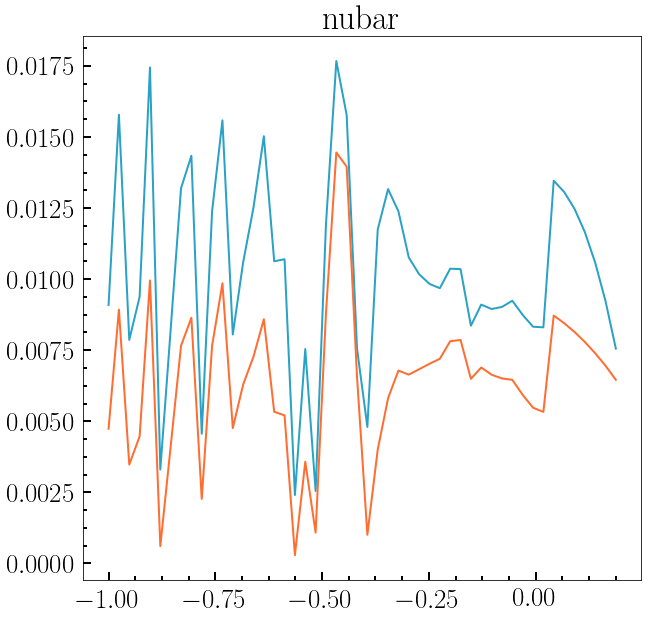

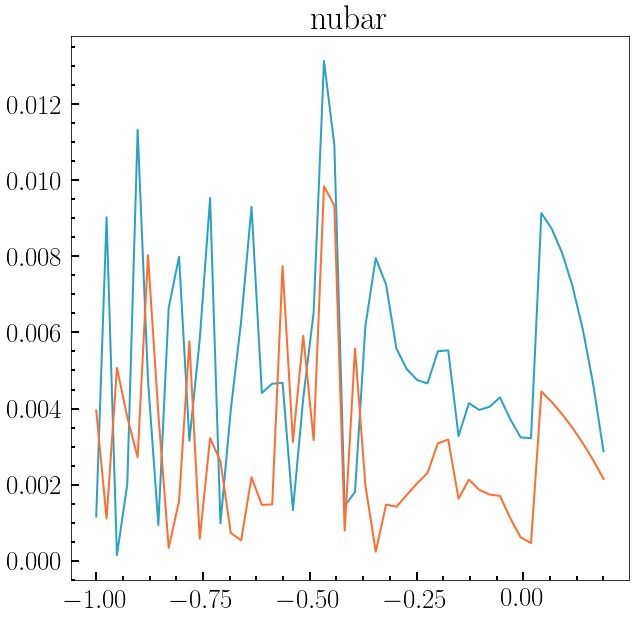

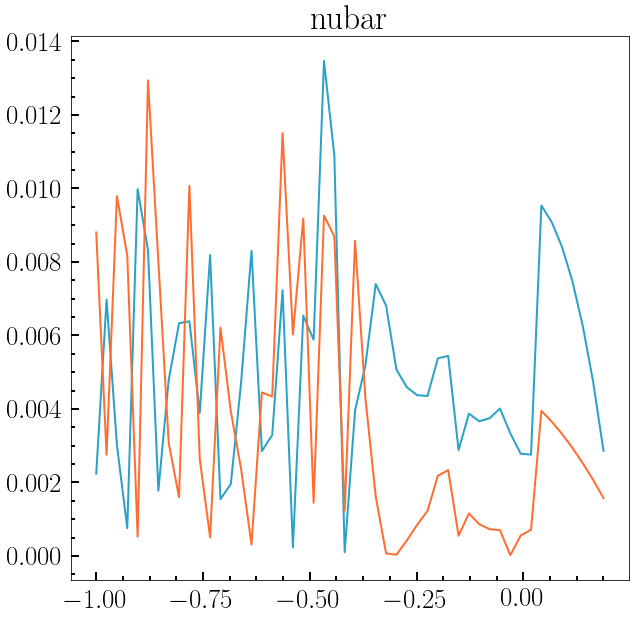

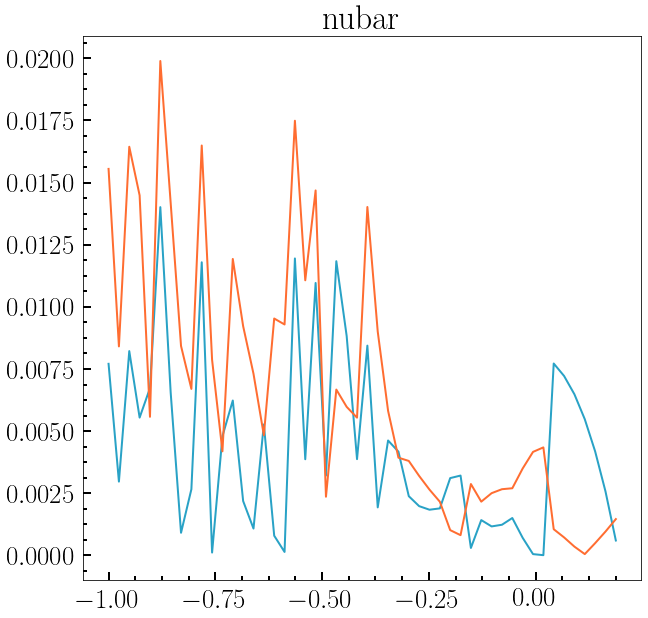

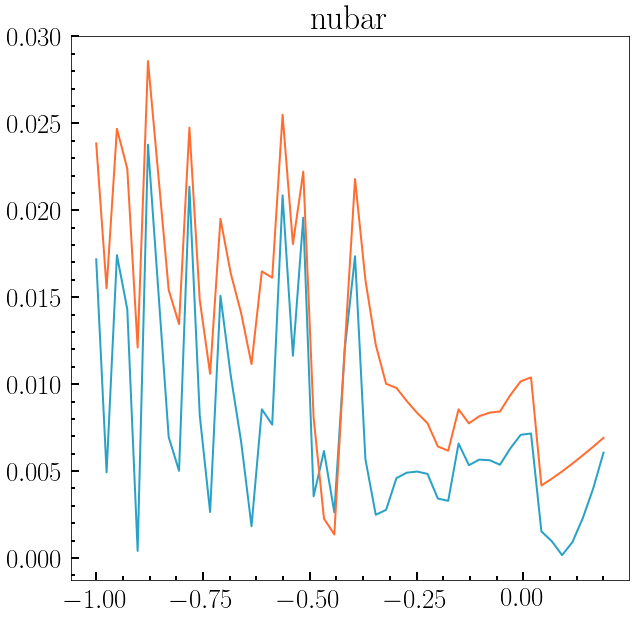

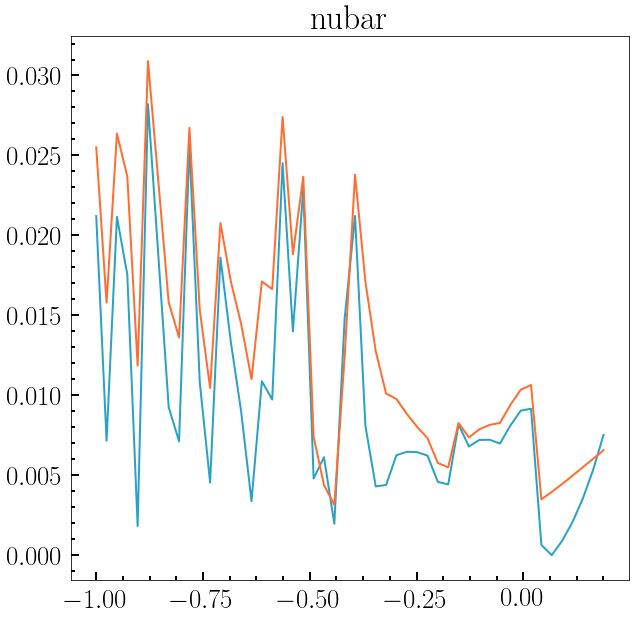

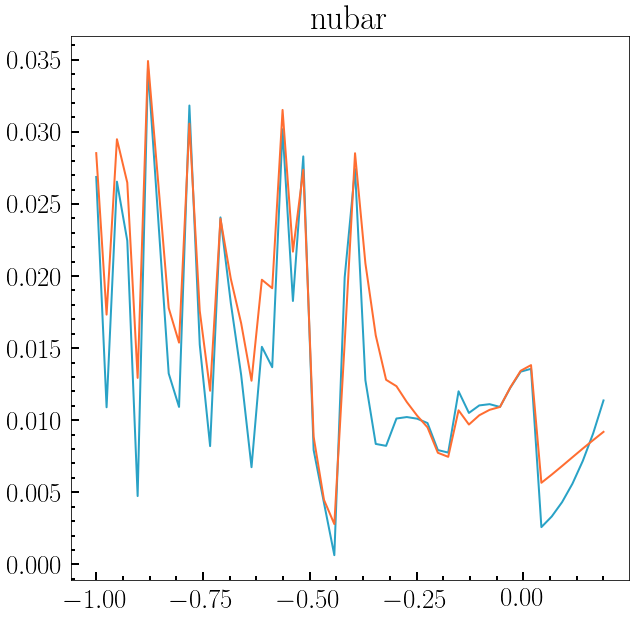

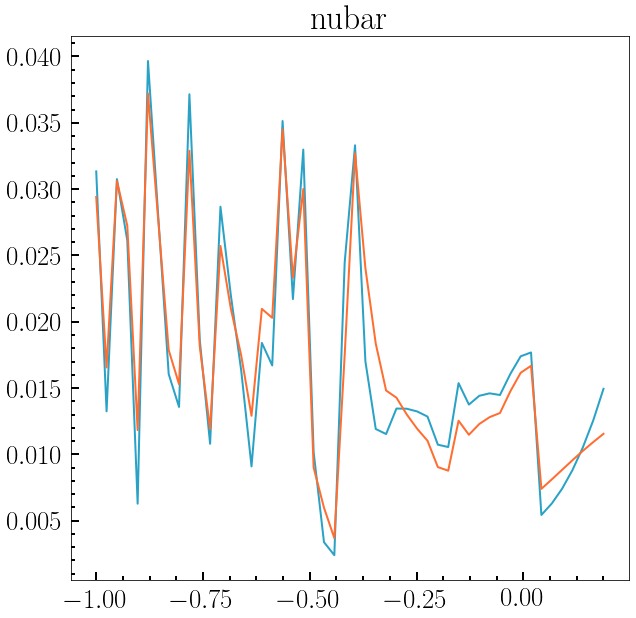

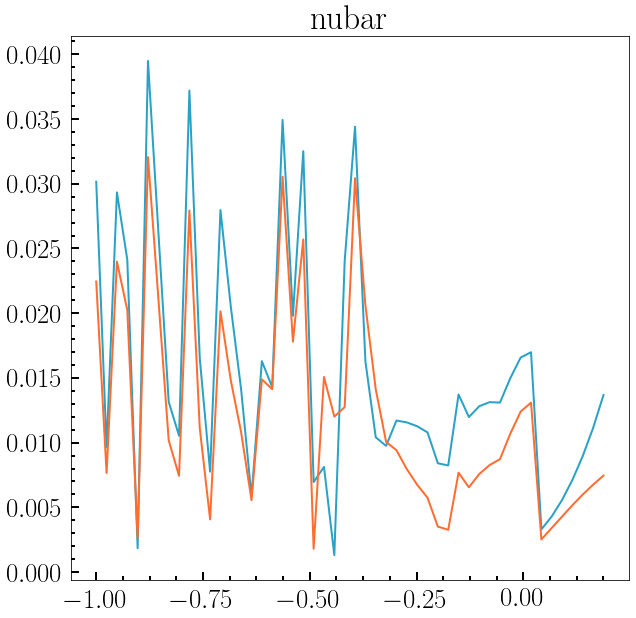

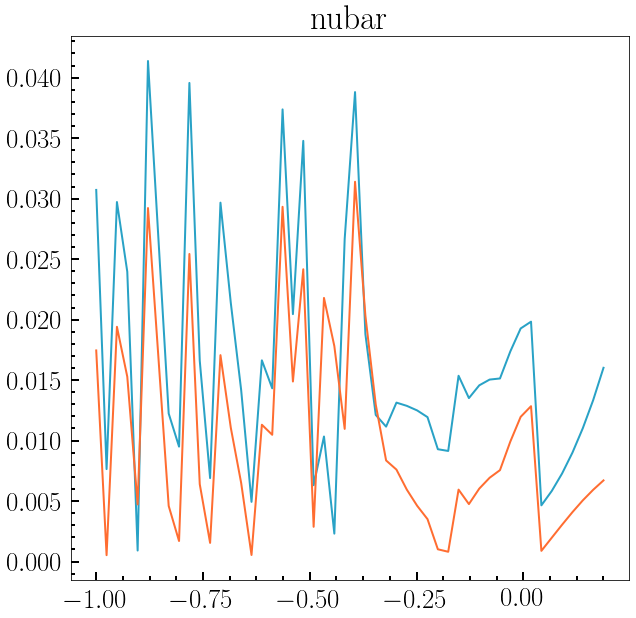

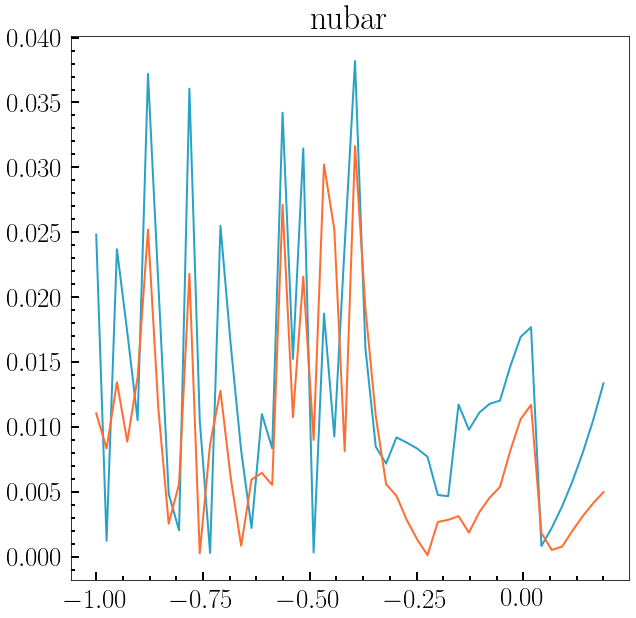

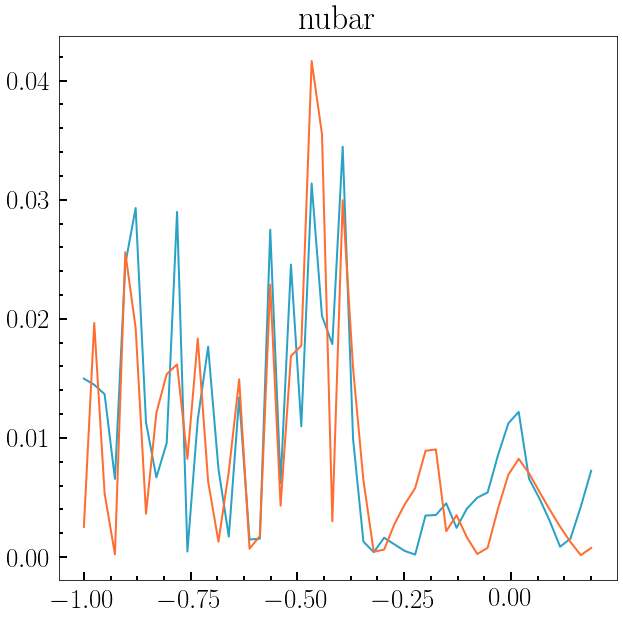

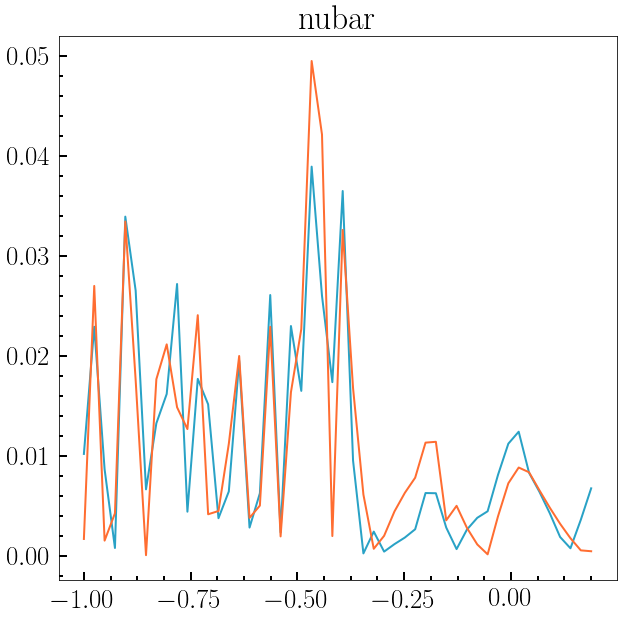

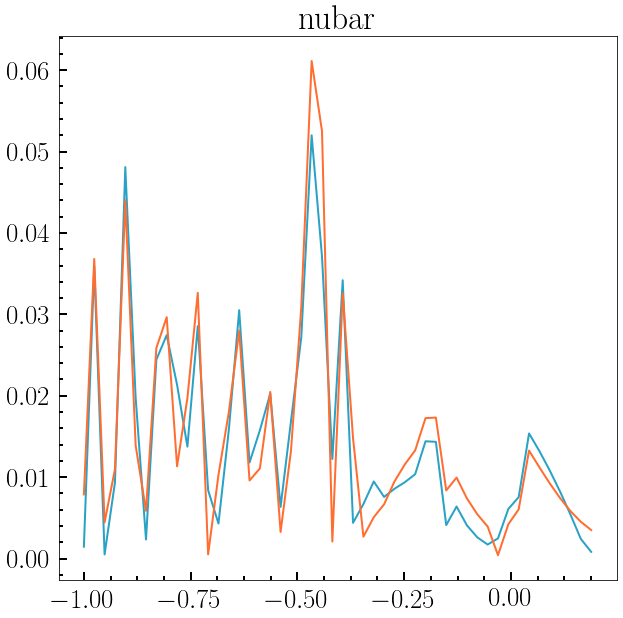

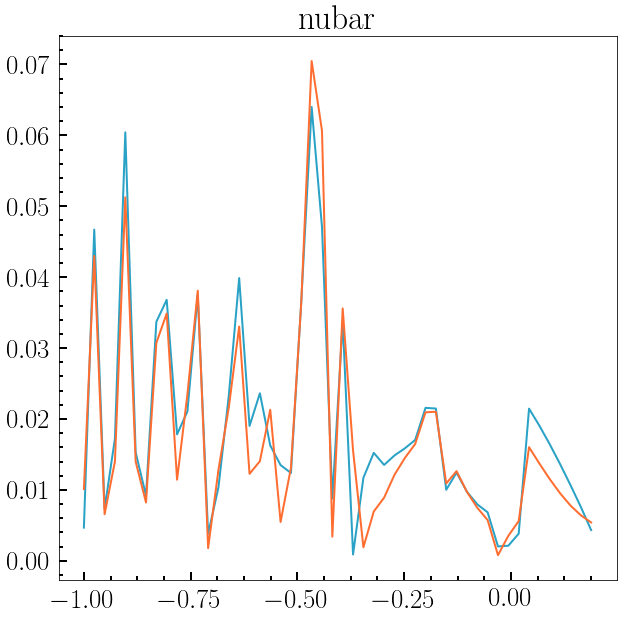

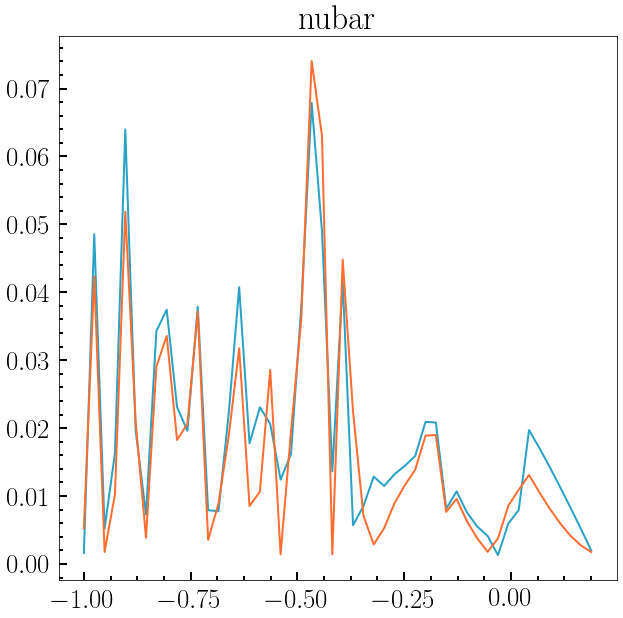

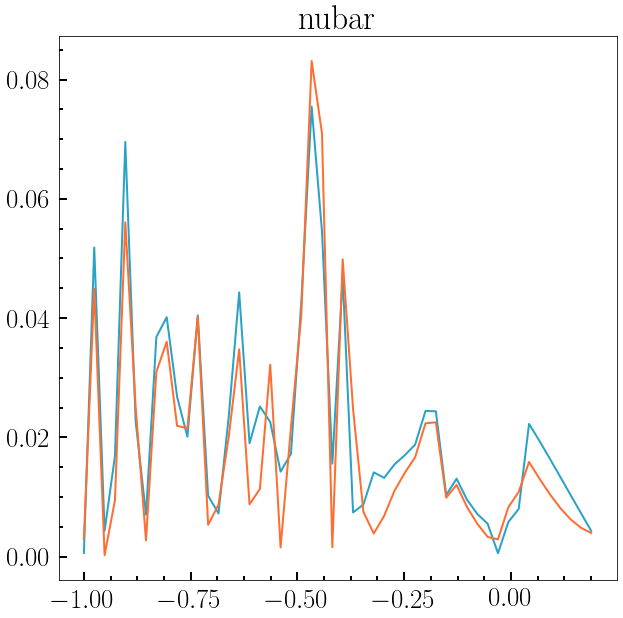

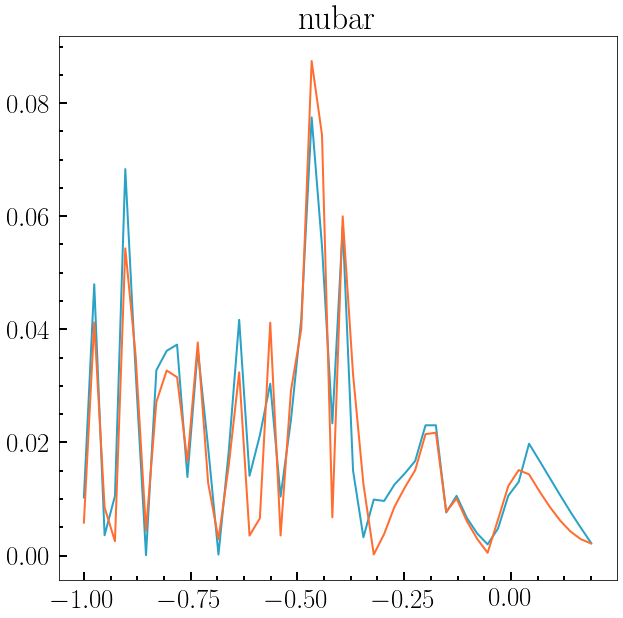

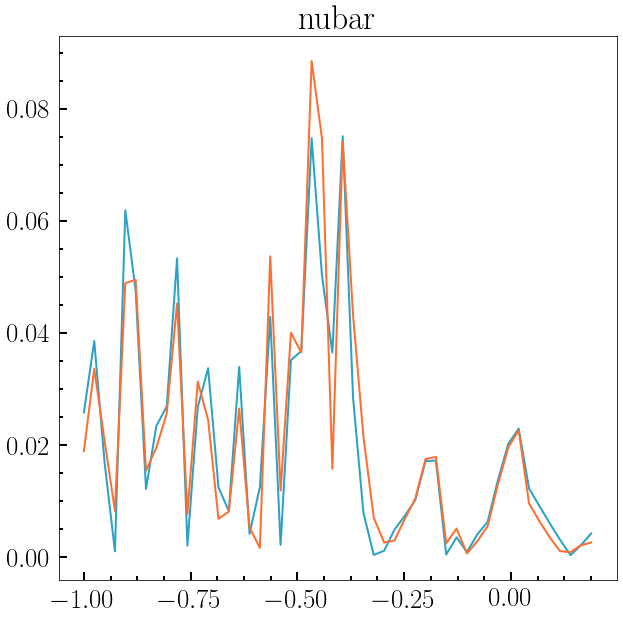

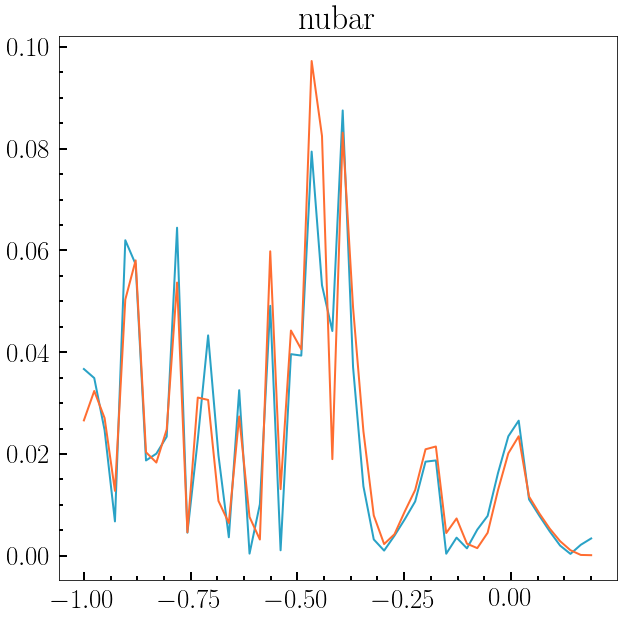

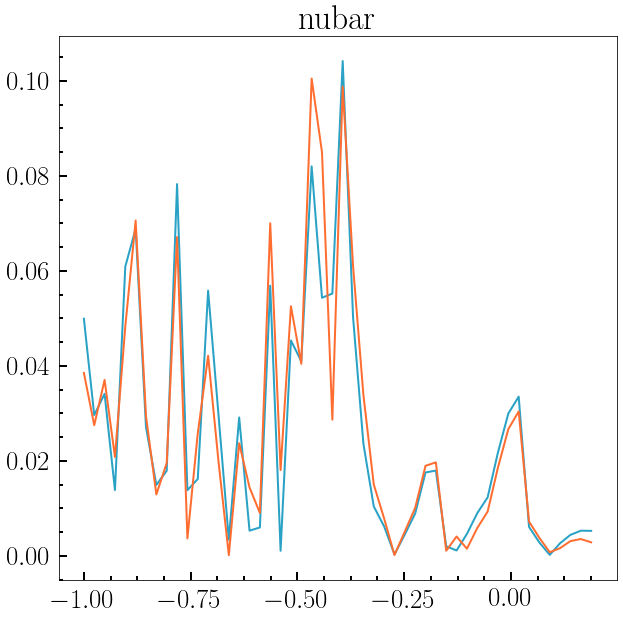

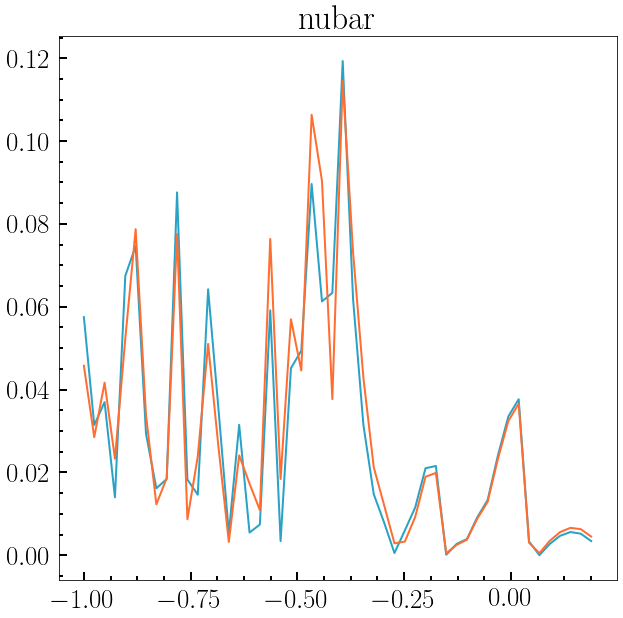

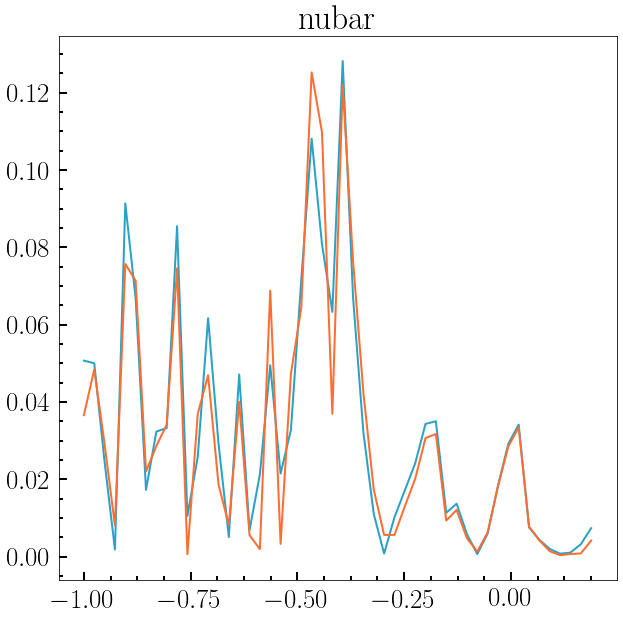

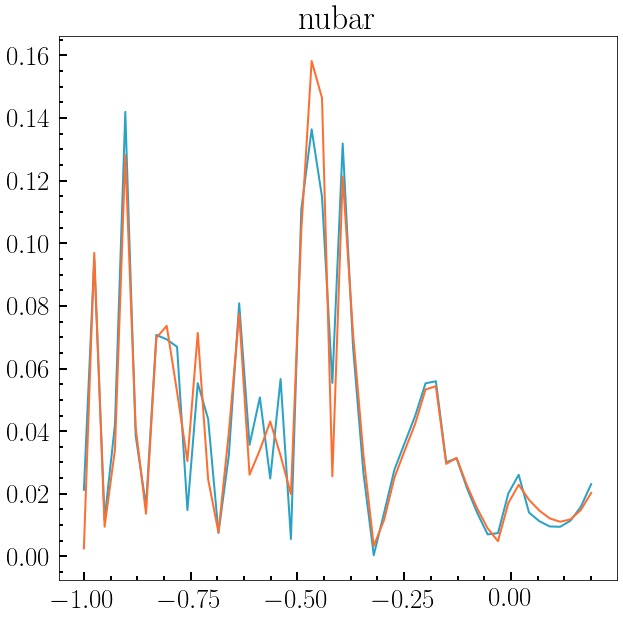

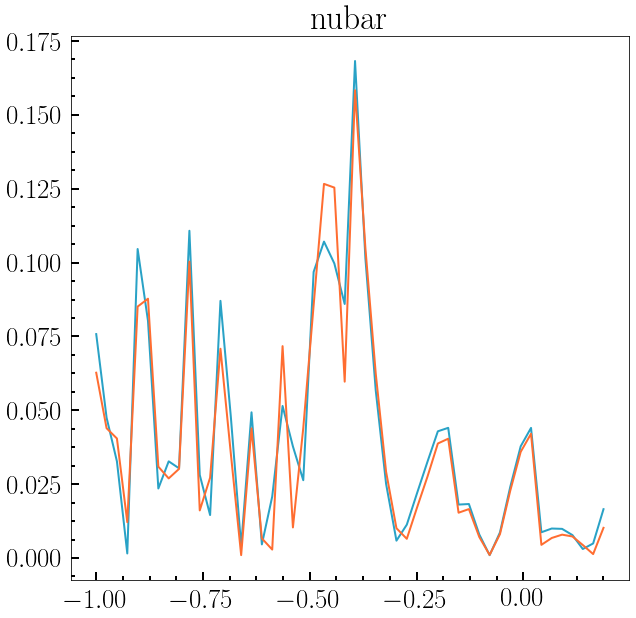

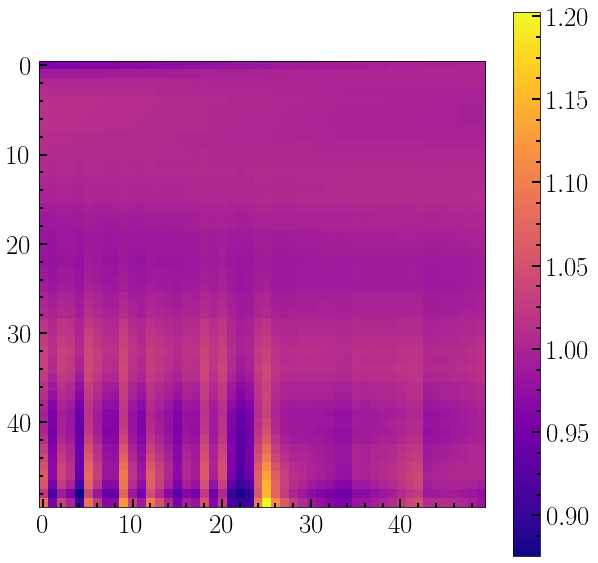

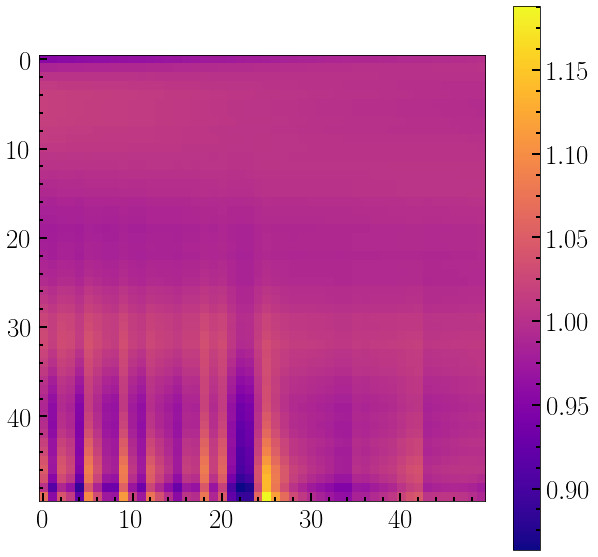

In [113]:
for nu_dist, nubar_dist, e in zip(conv_detector_flux[:,0,1,:], conv_detector_flux[:,1,1,:], conv_ee):
    plt.plot(conv_czens, np.abs(nu_dist-np.array([get_conv_flux(e, np.arccos(cz), 14) for cz in conv_czens]))/nu_dist)
#     plt.plot(conv_czens, [get_conv_flux(e, np.arccos(cz), 14) for cz in conv_czens])
#     plt.semilogy()
#     plt.title('nu')
#     plt.show()
    plt.plot(conv_czens, np.abs(nubar_dist-np.array([get_conv_flux(e, np.arccos(cz), -14) for cz in conv_czens]))/nubar_dist)
#     plt.plot(conv_czens, [get_conv_flux(e, np.arccos(cz), -14) for cz in conv_czens])
#     plt.semilogy()
    plt.title('nubar')
    plt.show()

nu_check = np.array([[get_conv_flux(e, np.arccos(cz), 14) for e in conv_ee] for cz in conv_czens]).T
plt.imshow(np.divide(conv_detector_flux[:,0,1,:], nu_check))
plt.colorbar()
plt.show()

nubar_check = np.array([[get_conv_flux(e, np.arccos(cz), -14) for e in conv_ee] for cz in conv_czens]).T
plt.imshow(np.divide(conv_detector_flux[:,1,1,:], nubar_check))
plt.colorbar()
plt.show()

### Interpolate conventional atm

In [150]:
mc_solar_flux = np.array([get_solar_flux(*tup) for tup in zip(NuEnergy, NuZenith, PrimaryType)])
mc_conv_flux = np.array([get_conv_flux(*tup) for tup in zip(NuEnergy, NuZenith, PrimaryType)])

lmc_solar_flux = np.log10(mc_solar_flux)
lmc_solar_flux = lmc_solar_flux[np.isfinite(lmc_solar_flux)]
lmc_conv_flux = np.log10(mc_conv_flux)
lmc_conv_flux = lmc_conv_flux[np.isfinite(lmc_conv_flux)]

/home/jlazar/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


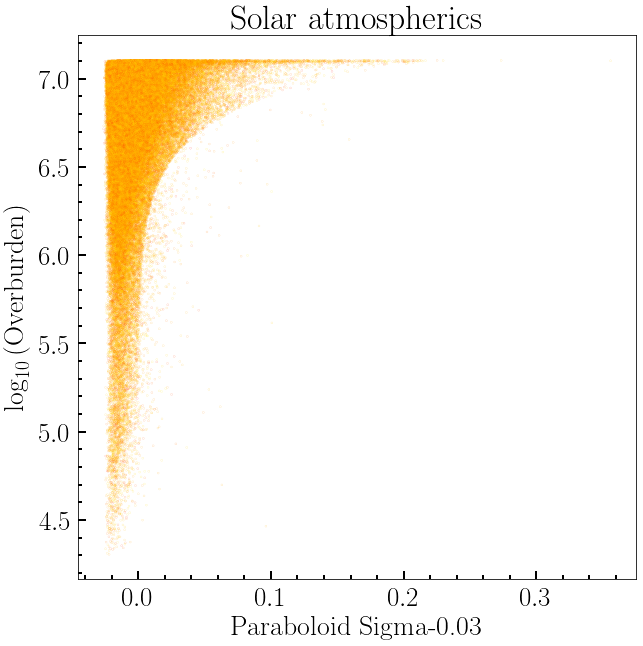

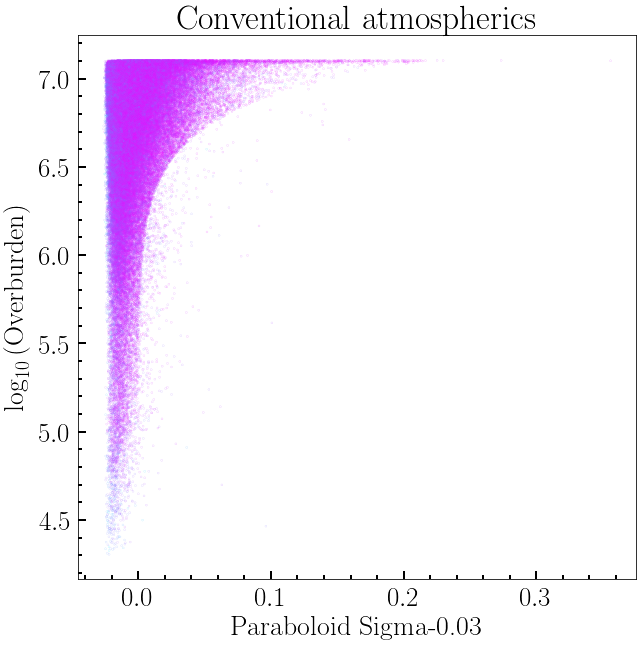

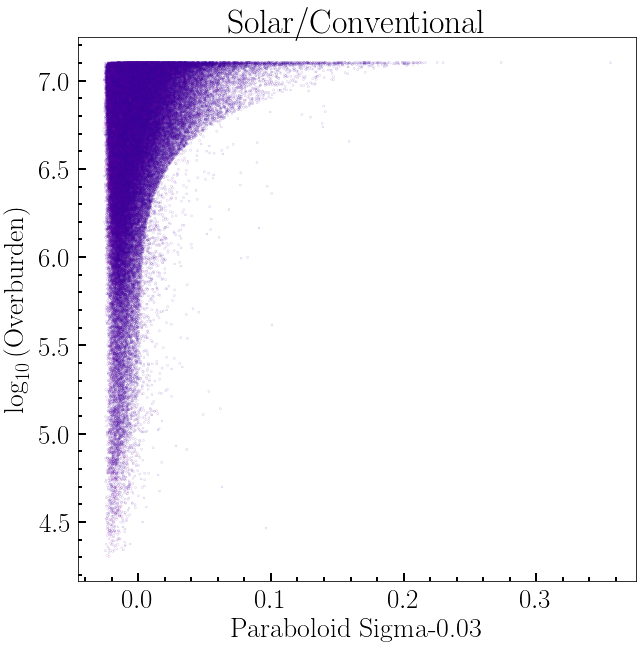

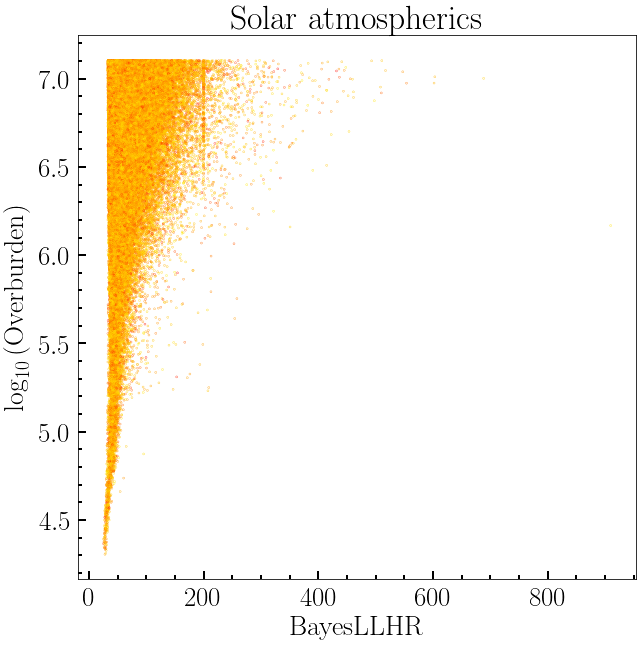

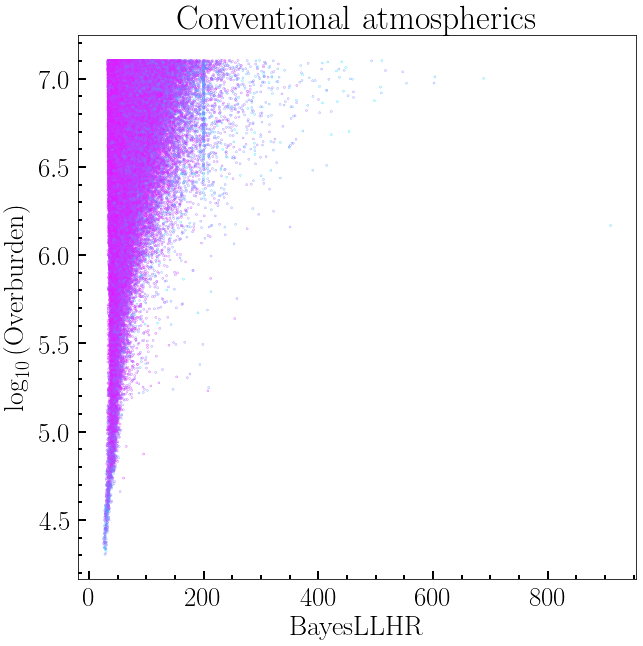

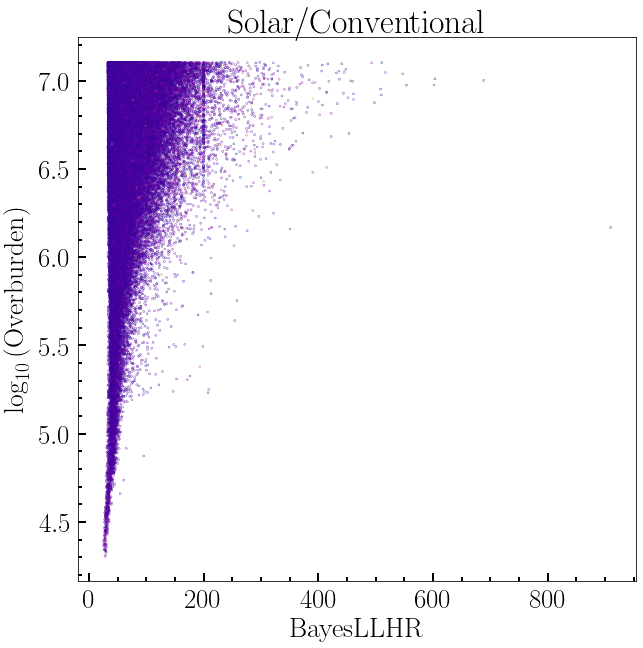

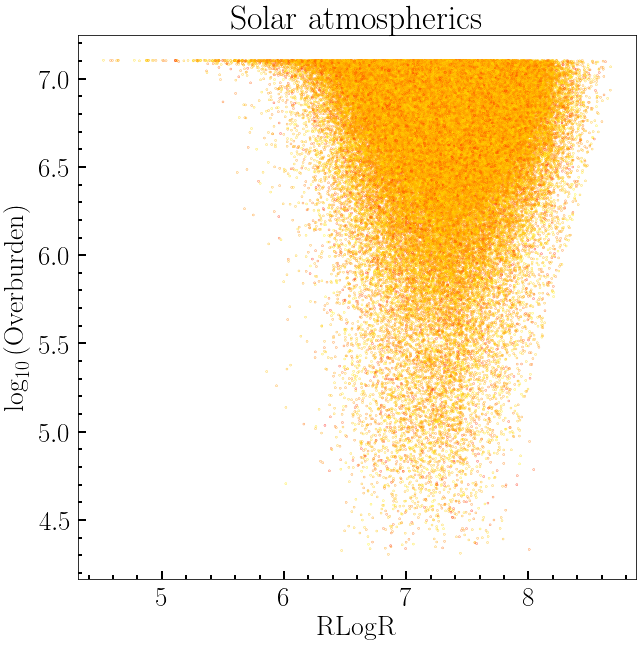

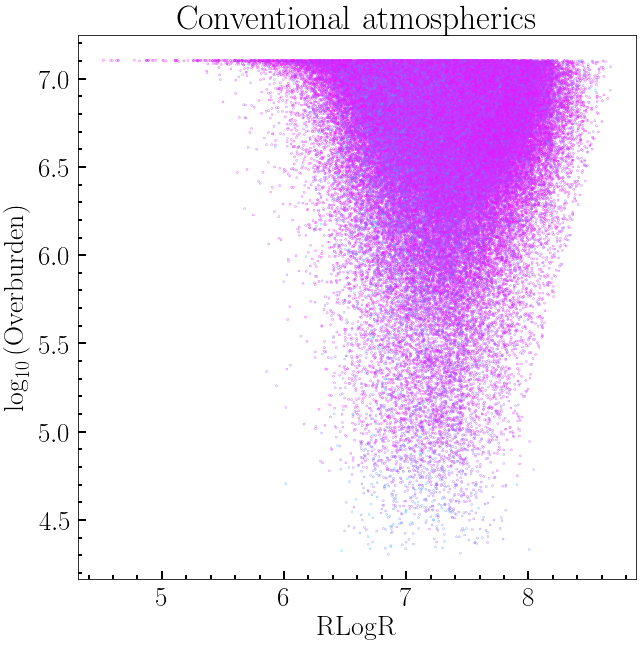

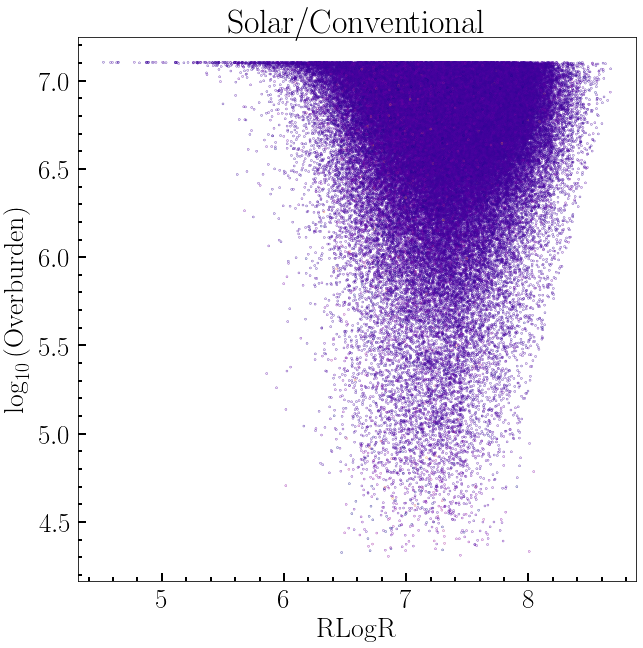

In [157]:
scaled_solar = (lmc_solar_flux - lmc_solar_flux.min()) / lmc_solar_flux.ptp()
solar_cs     = plt.cm.autumn(scaled_solar)
scaled_conv  = (lmc_conv_flux - lmc_conv_flux.min()) / lmc_conv_flux.ptp()
conv_cs      = plt.cm.cool(scaled_conv)

plt.scatter(ParaboloidSigma[::10]-0.03, np.log10(Overburden[::10]), c=solar_cs[::10], s=0.01, zorder=10)
plt.xlabel('Paraboloid Sigma-0.03')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.title('Solar atmospherics')
plt.show()
plt.scatter(ParaboloidSigma[::10]-0.03, np.log10(Overburden[::10]), c=conv_cs[::10], s=0.01)
plt.xlabel('Paraboloid Sigma-0.03')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.title('Conventional atmospherics')
plt.show()
plt.scatter(ParaboloidSigma[::10]-0.03, np.log10(Overburden[::10]), c=np.divide(mc_solar_flux,mc_conv_flux)[::10], s=0.01)
plt.xlabel('Paraboloid Sigma-0.03')
plt.title('Solar/Conventional')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.show()

plt.scatter(BayesLLHR[::10], np.log10(Overburden[::10]), c=solar_cs[::10], s=0.1)
plt.xlabel('BayesLLHR')
plt.title('Solar atmospherics')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.show()
plt.scatter(BayesLLHR[::10], np.log10(Overburden[::10]), c=conv_cs[::10], s=0.1)
plt.xlabel('BayesLLHR')
plt.title('Conventional atmospherics')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.show()
plt.xlabel('BayesLLHR')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.title('Solar/Conventional')
plt.scatter(BayesLLHR[::10], np.log10(Overburden[::10]), c=np.divide(mc_solar_flux,mc_conv_flux)[::10], s=0.1)
plt.show()

plt.scatter(RLogL[::10], np.log10(Overburden[::10]), c=solar_cs[::10], s=0.1)
plt.title('Solar atmospherics')
plt.xlabel('RLogR')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.show()
plt.scatter(RLogL[::10], np.log10(Overburden[::10]), c=conv_cs[::10], s=0.1)
plt.title('Conventional atmospherics')
plt.xlabel('RLogR')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.show()
plt.scatter(RLogL[::10], np.log10(Overburden[::10]), c=np.divide(mc_solar_flux,mc_conv_flux)[::10], s=0.1)
plt.xlabel('RLogR')
plt.title('Solar/Conventional')
plt.ylabel(r'$\log_{10}\left(\rm{Overburden}\right)$')
plt.show()

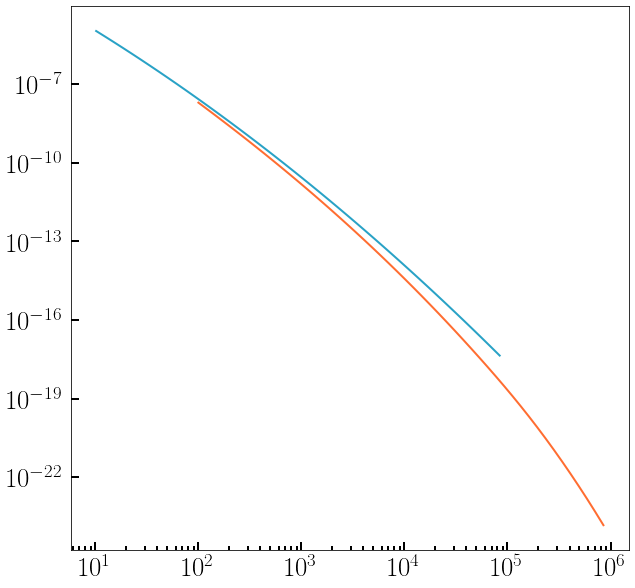

In [134]:
plt.plot(solar_ee, [get_solar_flux(e, 3*np.pi/4, 14) for e in solar_ee])
plt.plot(conv_ee, [get_conv_flux(e, 3*np.pi/4, 14) for e in conv_ee])
plt.loglog()
plt.show()